# Training example TPV 36-3D

TPV 36-3D is a benchmark exercise that is designed to test if computer codes that simulate dynamic earthquake rupture are working as intended [(Harris et al., SRL 2018)](https://pubs.geoscienceworld.org/ssa/srl/article/89/3/1146/530061/A-Suite-of-Exercises-for-Verifying-Dynamic). It was designed by the [SCEC/USGS Spontaneous Rupture Code Verification Project](https://strike.scec.org/cvws/) and features:

* spontaneous rupture on a 2D planar 15-degree dipping thrust fault  
* homogeneous half-space: $V_p=6000\,m/s, V_s=3464\,m/s, \rho=2670\,kg/m^3$
* linear-slip weakening (LSW) friction 
* initial stress conditions are depth-dependent 

[Detailed benchmark description (SCEC)](https://strike.scec.org/cvws/tpv36_37docs.html).

# Off-fault receivers

In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Prepare off-fault receivers for TPV upload

### For loop processing SeisSol receivers (off-fault)

In [5]:
# Folder where the processed receivers will be saved
output_folder = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1"
# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

#VARIABLES = "Time","xx","yy","zz","xy","yz","xz","v1","v2","v3"
VARIABLES = "Time","xx","yy","zz","xy","yz","xz","v1","v2","v3","damage","breakage"
filenames = "*-receiver*.dat"

files = glob.glob(os.path.join("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/tpv36_branch_Zihua_v1/", filenames))
for f in files:
    # Coordinates 
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]/1e3 # to km
    x2 = coords[2][1]/1e3
    x3 = coords[2][2]/1e3
    if x2 < 0:
        file = "body{:03d}0st{:02d}0dp{:02d}0.csv".format(int(x2),int(x1),int(x3))
    else:
        file = "body{:02d}0st{:02d}0dp{:02d}0.csv".format(int(x2),int(x1),int(x3))
    print("\nProcessing: ",file)
    print("Location = {:2.1f} km off-fault, {:2.1f} km along strike, {:2.1f} km depth".format(x2,x1,x3))
    
    # Off-fault receiver data
    df = pd.read_csv(f, skiprows=5, sep='\s+', names=VARIABLES)
    df['v3'] *= -1 # vertical component needs to be flipped
    time_step = df['Time'][1] - df['Time'][0]
    num_time_steps = len(df)
    print("Time step, length:", time_step, num_time_steps)
    df.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
    # Integrate
    df["u1"] = np.cumsum(df['v1']) * time_step
    df["u2"] = np.cumsum(df['v2']) * time_step
    df["u3"] = np.cumsum(df['v3']) * time_step
    df.rename({"Time": "t", "v1": "h-vel", "u1": "h-disp", "v2": "n-vel", "u2": "n-disp", "v3": "v-vel", "u3": "v-disp"}, axis=1, inplace=True)
    df = df.loc[:,["t", "h-disp", "h-vel", "v-disp", "v-vel", "n-disp", "n-vel"]] # re-order columns
    tmp_receiver = os.path.join(output_folder, "tmp_receiver.csv")
    receiver = os.path.join(output_folder, file)
    df.to_csv(tmp_receiver, index=False, sep=" ", float_format="%.7e")

    # Content with placeholders for the values
    file_content = """# problem = TPV36
# author = Fabian Kutschera
# date = 2024/09/17
# code = SeisSol
# code_version = TBD
# element_size = 200.0 m (o4)
# time_step = {} (s)
# num_time_steps = {}
# location = {:2.1f} km off-fault, {:2.1f} km along strike, {:2.1f} km depth
# Column #1 = Time (s)
# Column #2 = horizontal displacement (m)
# Column #3 = horizontal velocity (m/s)
# Column #4 = vertical displacement (m)
# Column #5 = vertical velocity (m/s)
# Column #6 = normal displacement (m)
# Column #7 = normal velocity (m/s)
#
# The line below lists the names of the data fields:
"""
    
    # Format the string 
    formatted_content = file_content.format(time_step, num_time_steps, x2, x1, x3)
    
    # Full path to the file
    tmp_file = os.path.join(output_folder, "tmp.txt")
    
    # Write the formatted content to the file
    with open(tmp_file, 'w') as file:
        file.write(formatted_content)
    
    !echo "$tmp_file" "$tmp_receiver" "$receiver"
    !cat "$tmp_file" "$tmp_receiver" > "$receiver"
    !rm "$tmp_file" "$tmp_receiver"


Processing:  body270st100dp000.csv
Location = 27.0 km off-fault, 10.0 km along strike, -0.0 km depth
Time step, length: 0.005 4401
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body270st100dp000.csv

Processing:  body010st000dp000.csv
Location = 1.0 km off-fault, 0.0 km along strike, -0.0 km depth
Time step, length: 0.005 4401
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body010st000dp000.csv

Processing:  body150st000dp000.csv
Location = 15.0 km off-fault, 0.0 km along strike, -0.0 km depth
Time step, length: 0.005 4401
/Users/fkutschera/Documents/Data/CRESCE

### Plot all processed receivers (off-fault) to compare against TPV results 

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body-090st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-090st100dp000.dat


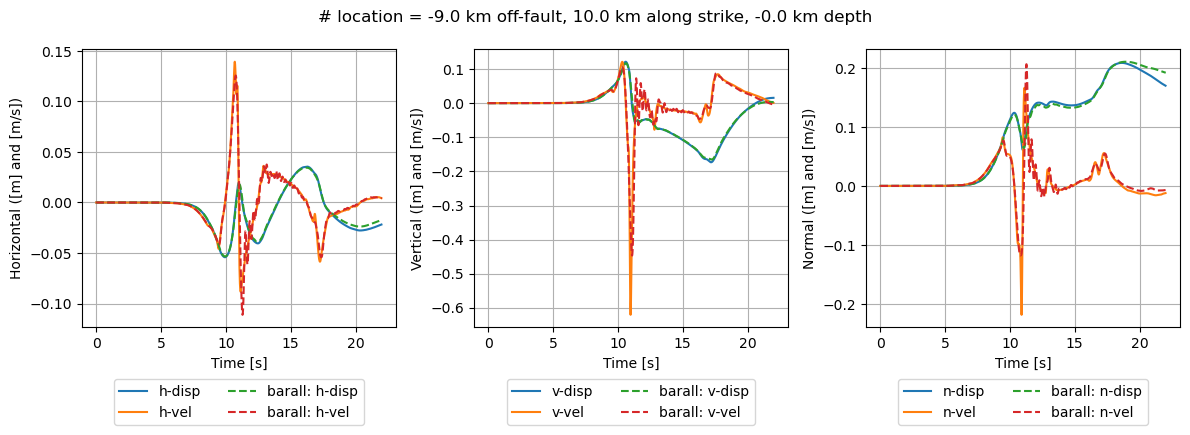

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body-010st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-010st100dp000.dat


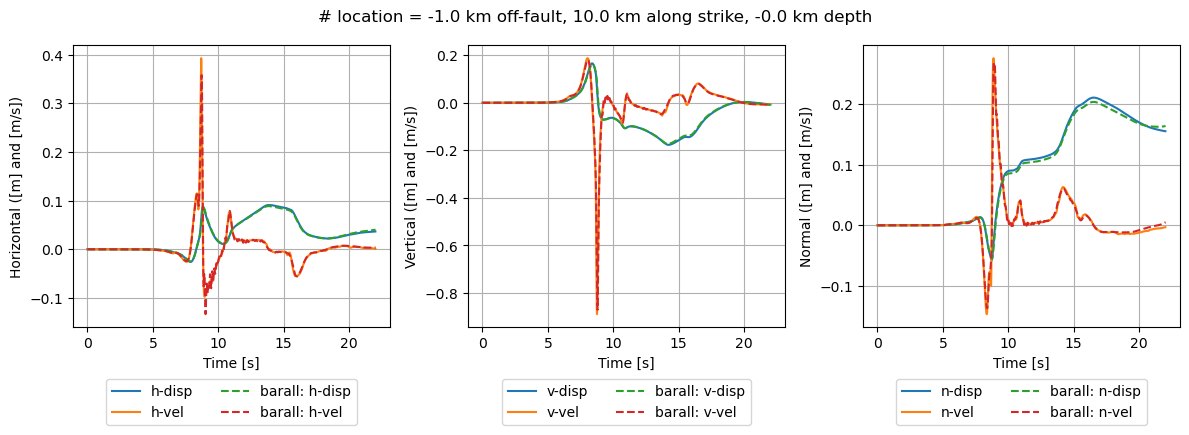

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body450st200dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body450st200dp000.dat


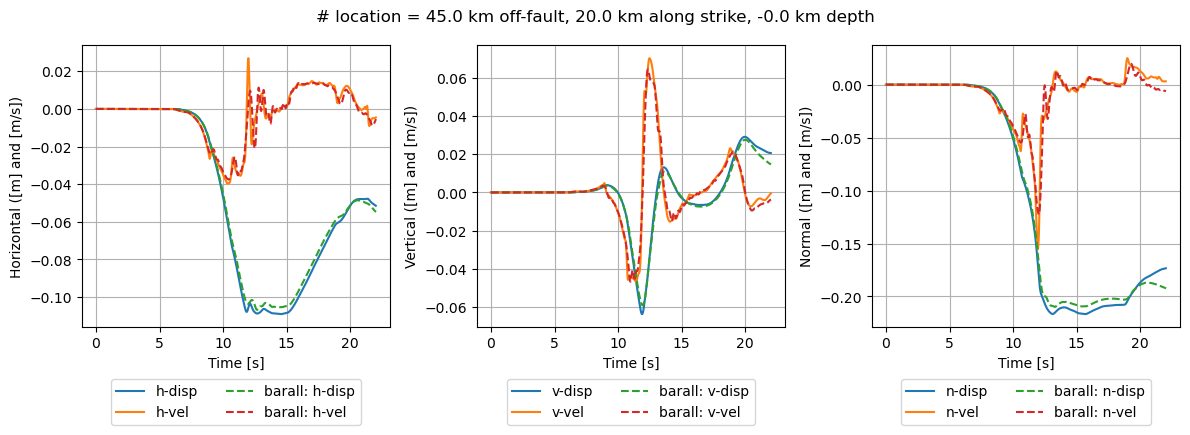

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body090st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body090st100dp000.dat


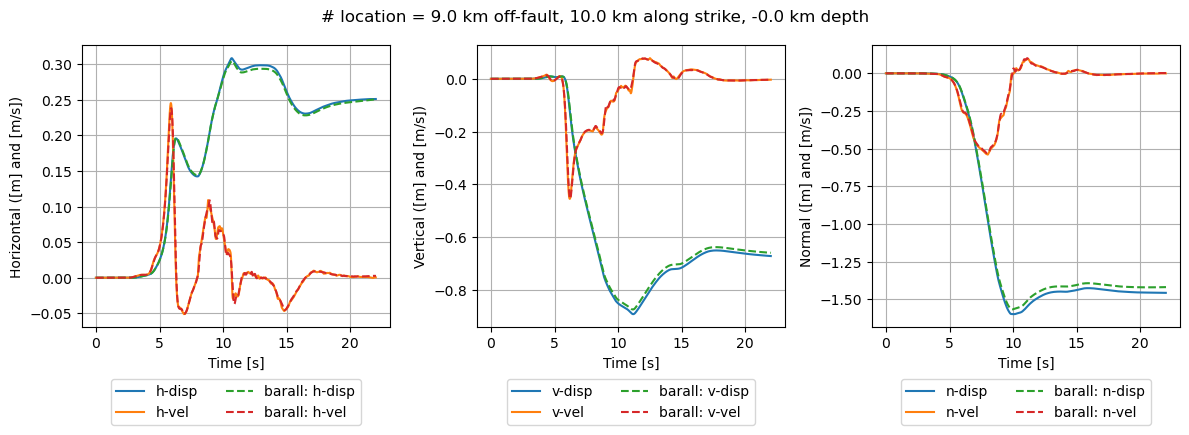

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body270st200dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body270st200dp000.dat


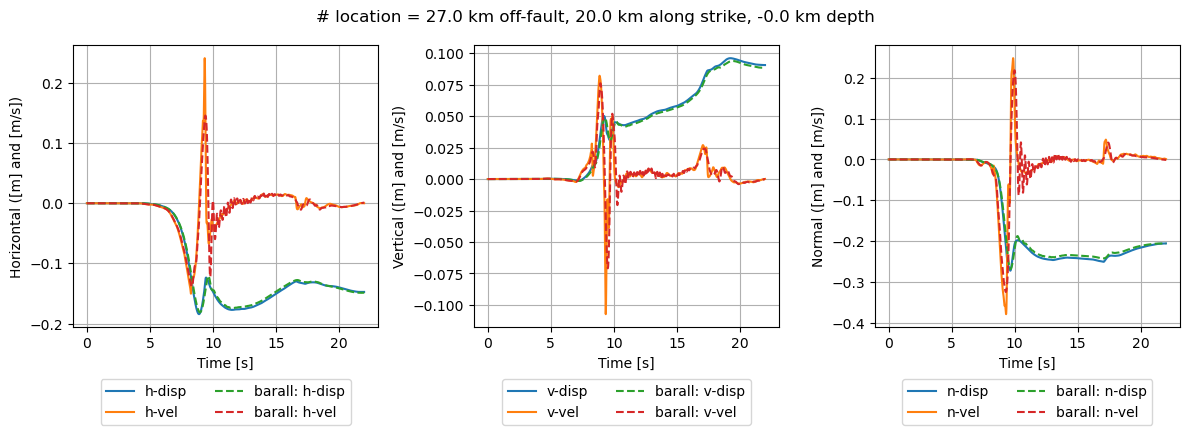

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body390st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body390st000dp000.dat


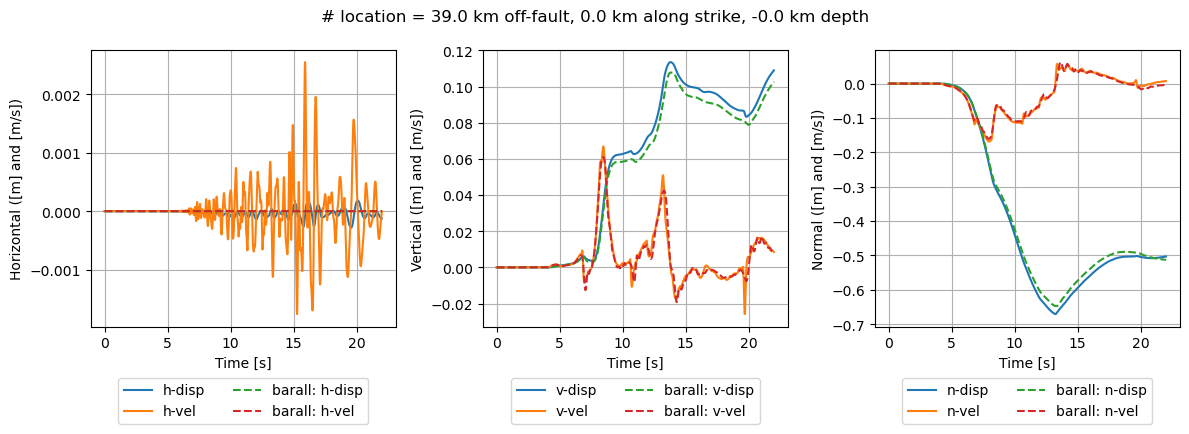

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body010st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body010st100dp000.dat


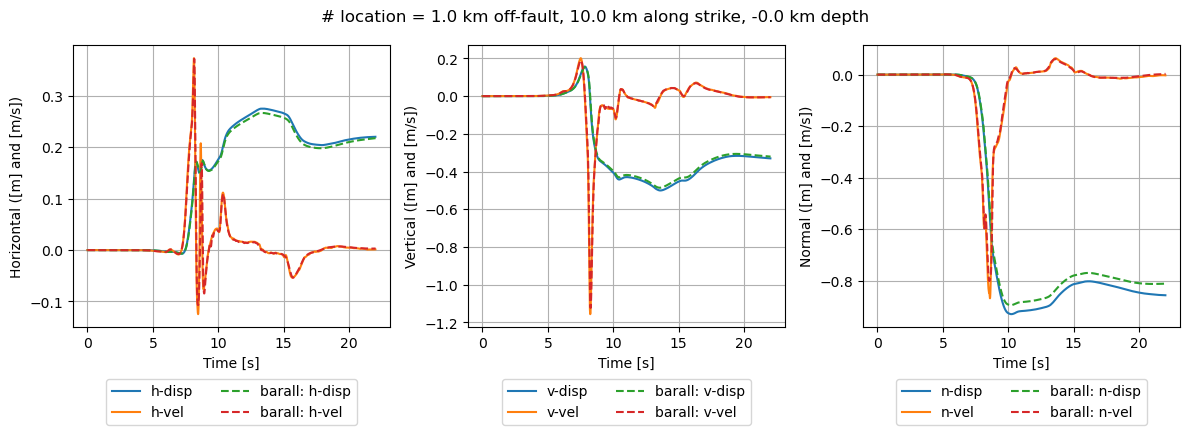

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body330st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body330st000dp000.dat


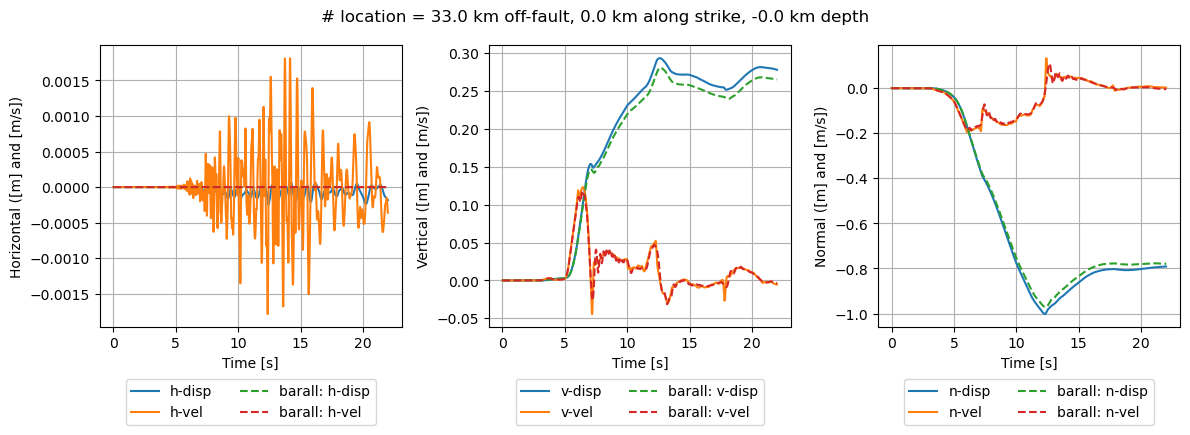

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body210st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body210st000dp000.dat


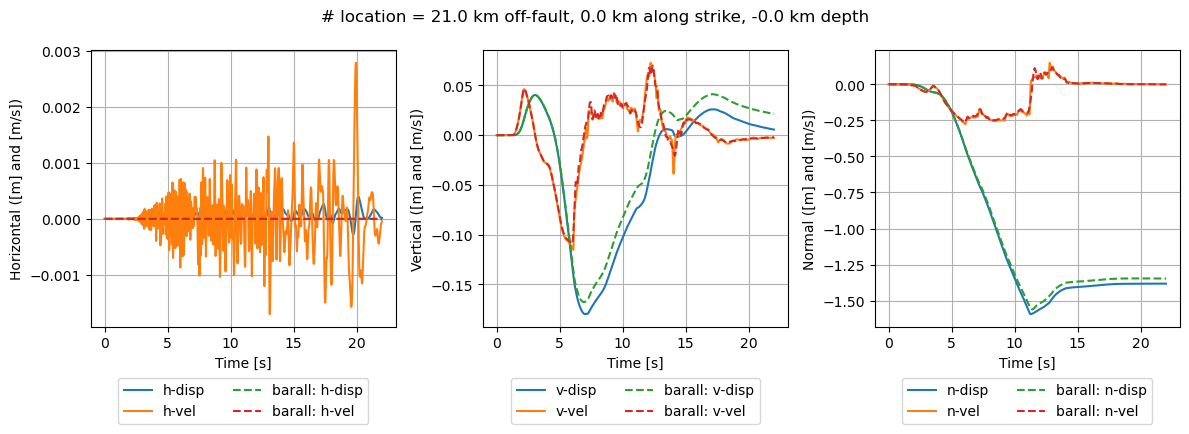

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body450st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body450st000dp000.dat


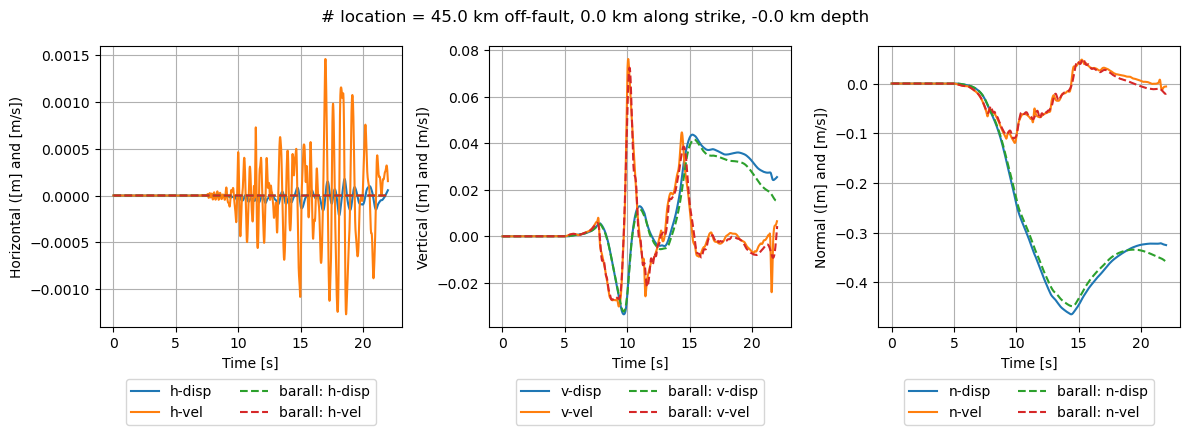

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body270st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body270st000dp000.dat


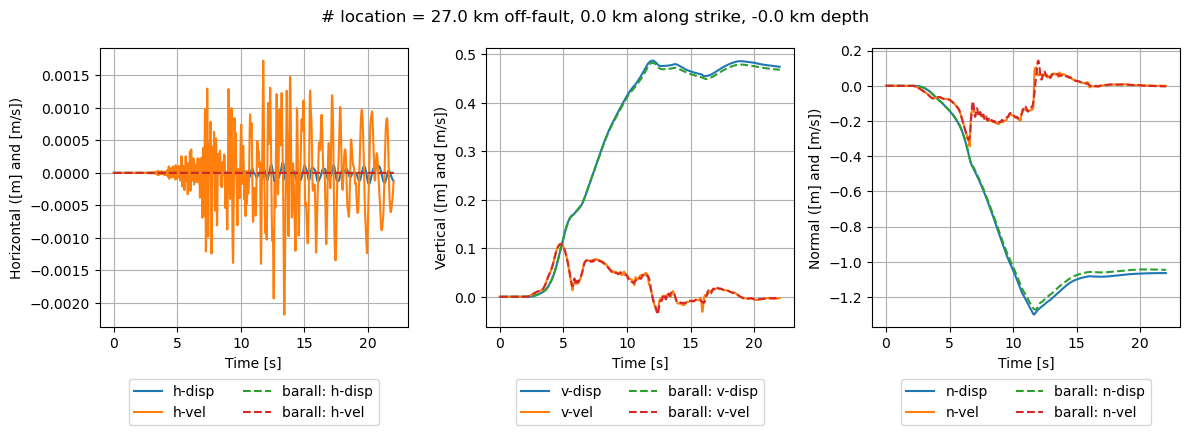

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body090st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body090st000dp000.dat


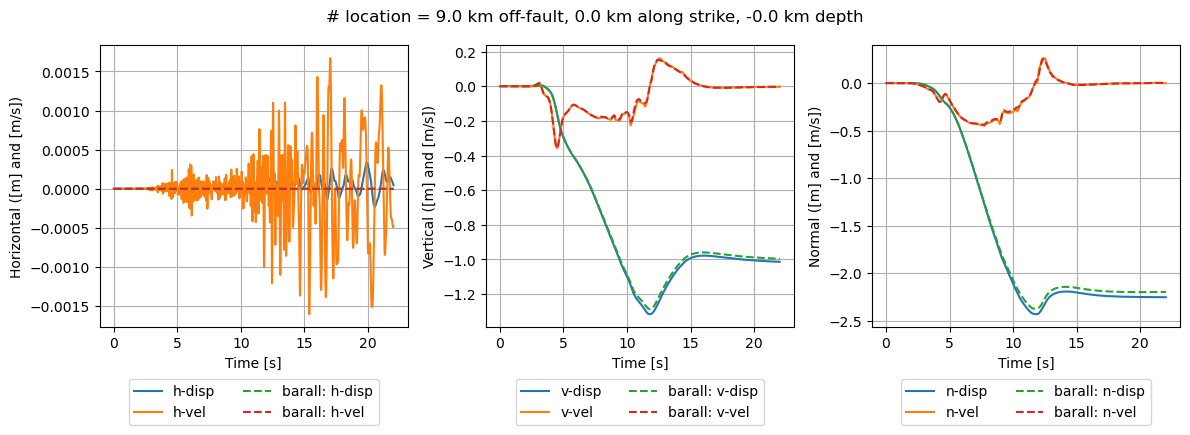

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body010st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body010st000dp000.dat


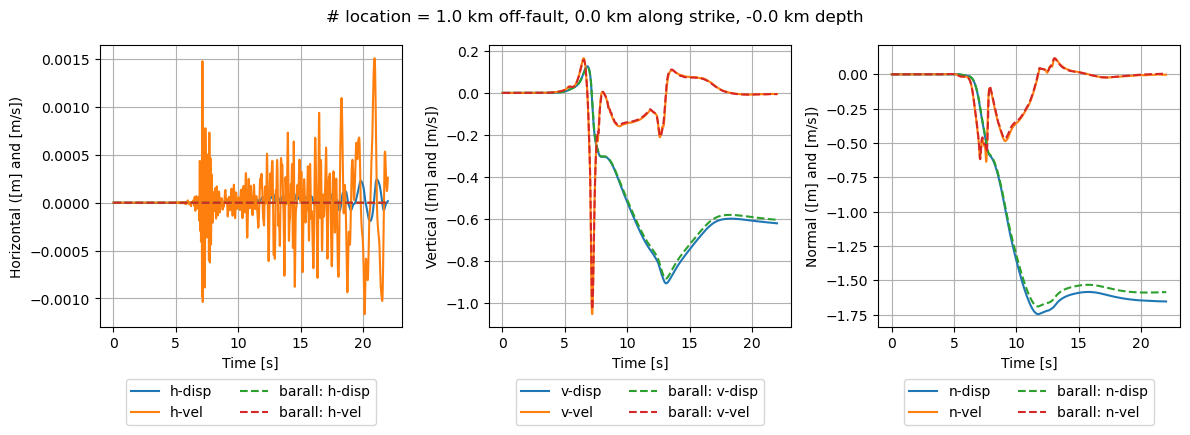

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body150st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body150st000dp000.dat


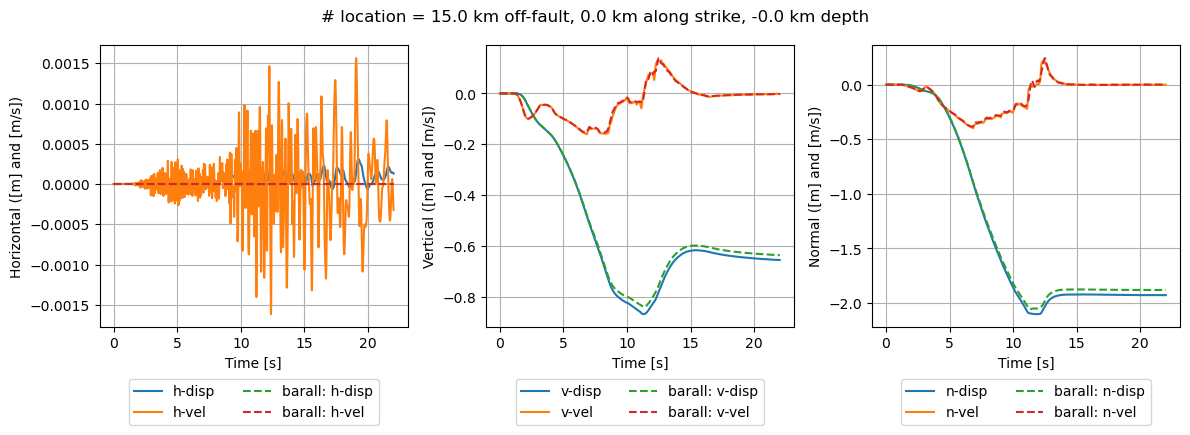

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body-090st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-090st000dp000.dat


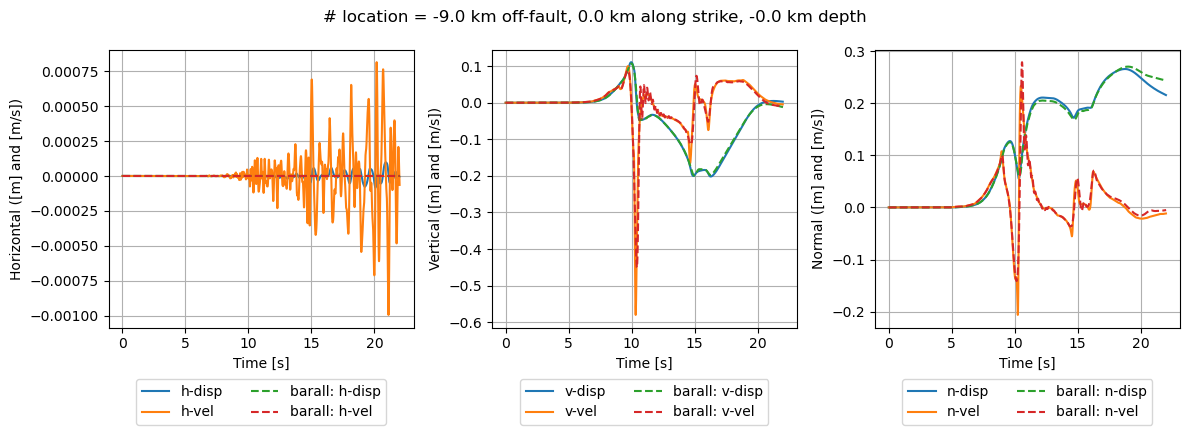

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body-010st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-010st000dp000.dat


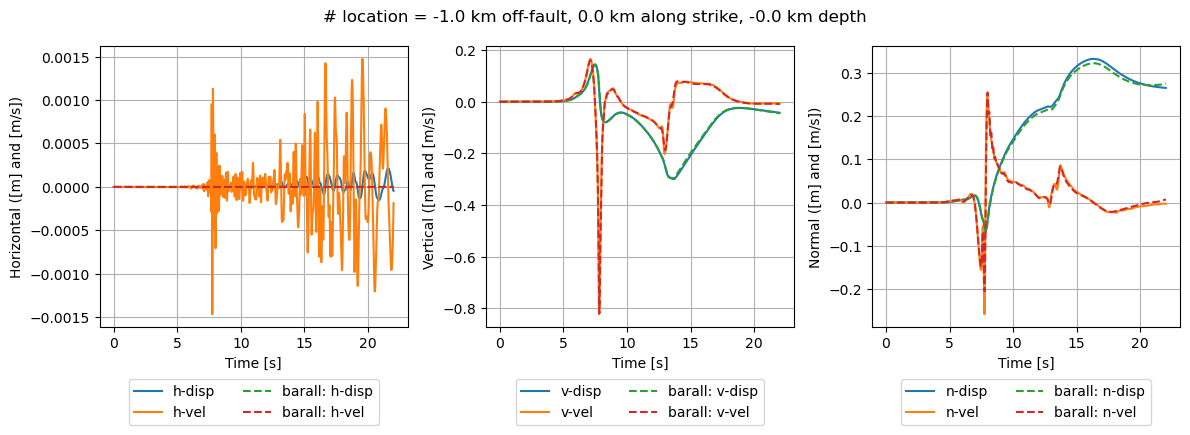

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body-030st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-030st000dp000.dat


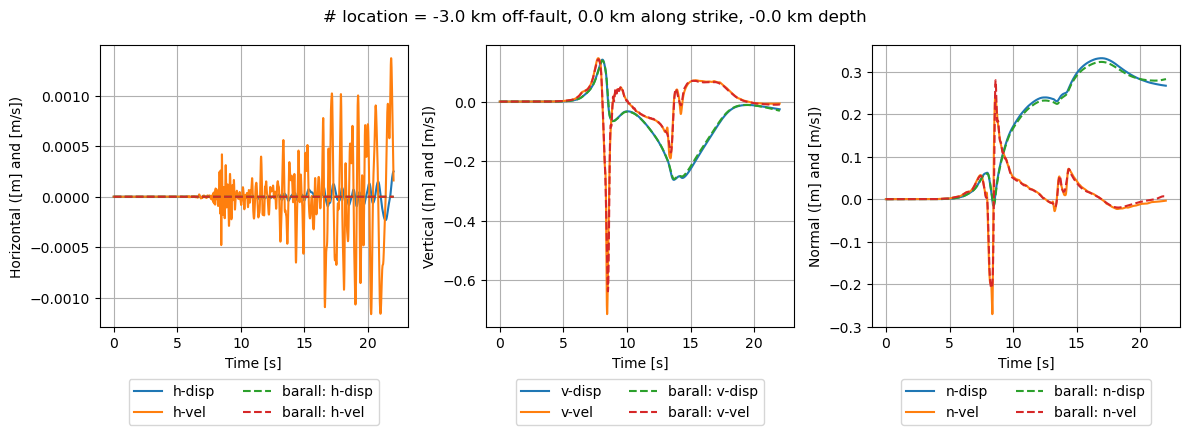

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body090st200dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body090st200dp000.dat


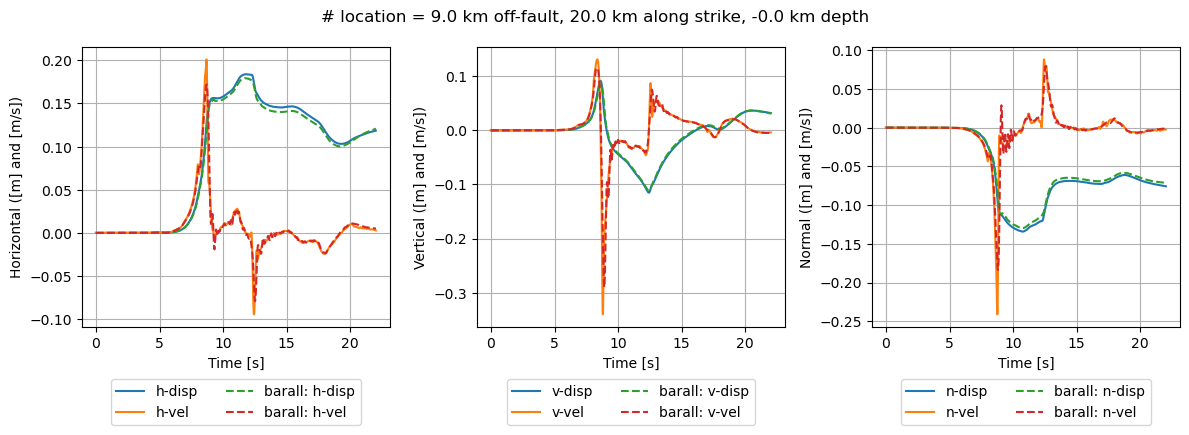

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body270st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body270st100dp000.dat


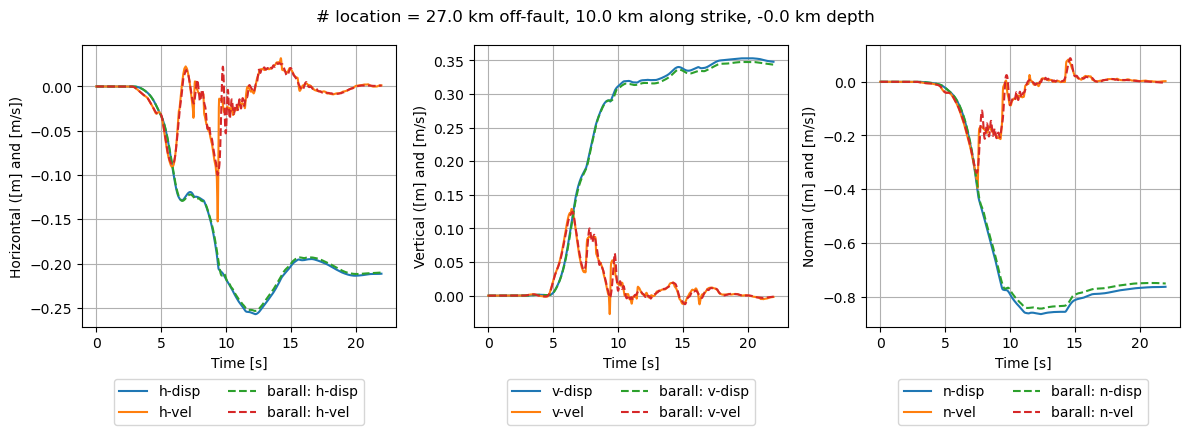

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body-090st200dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body-090st200dp000.dat


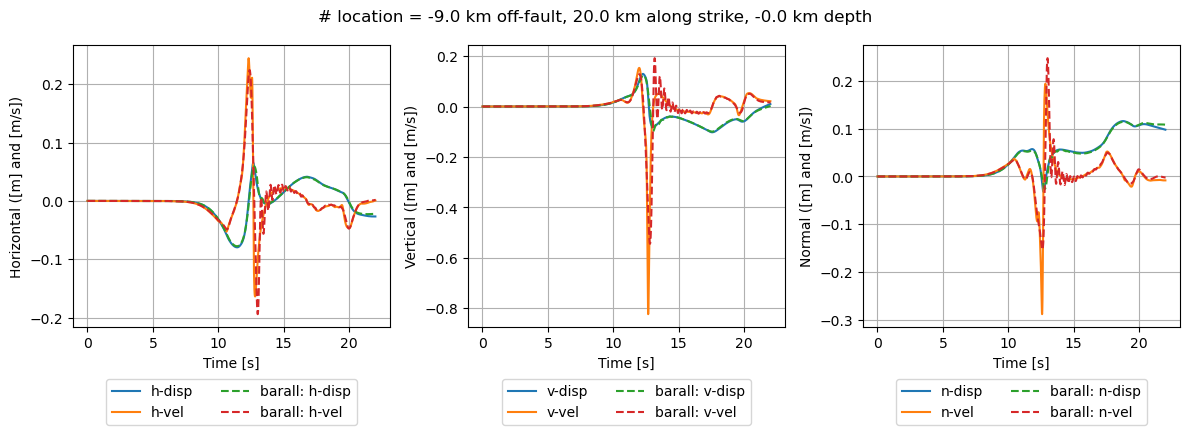

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body030st000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body030st000dp000.dat


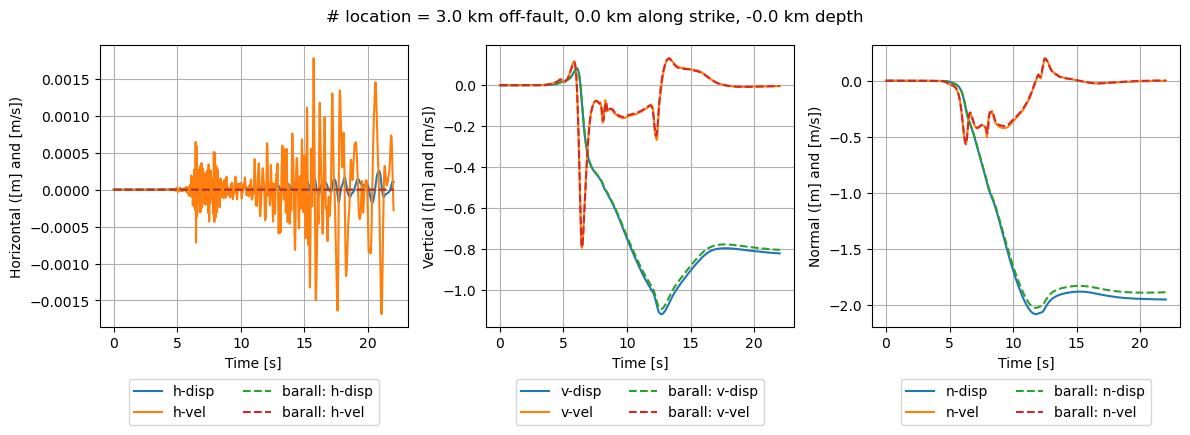

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/body450st100dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/body450st100dp000.dat


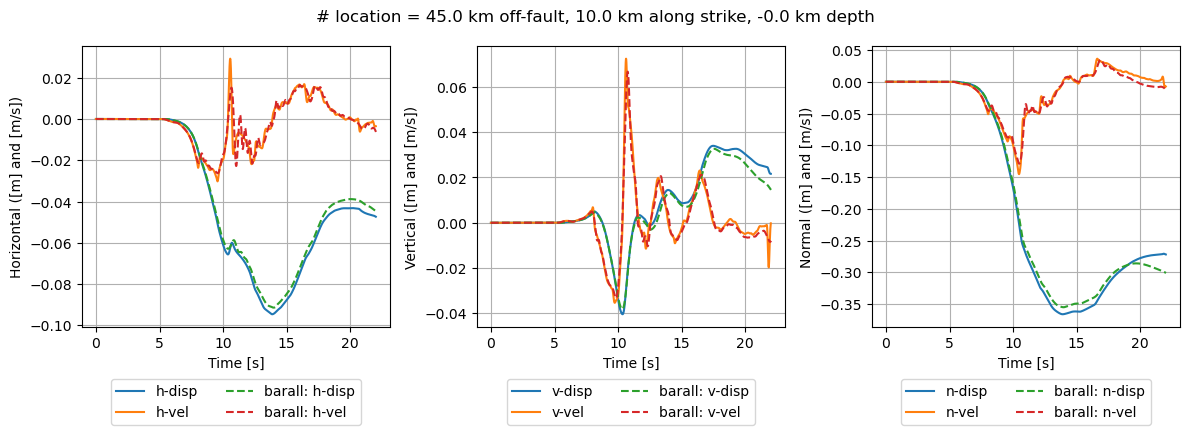

In [6]:
filenames = "body*.csv"

files = glob.glob(os.path.join(output_folder, filenames))

for f in files:
    print(f)

    df_title = pd.read_csv(f, skiprows=8, nrows=1, sep=";", header=None) #arbitray separator
    title = df_title.iloc[0][0]
    
    df = pd.read_csv(f, sep="\s+", comment="#")
    if len(f.split('-')) > 1:
        f_barall = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/"+f[-22:-4]+".dat"
    else:
        f_barall = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/"+f[-21:-4]+".dat"
    print(f_barall)
    barall = pd.read_csv(f_barall, sep="\s+", comment="#") 
    
    # Create figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))
    fig.suptitle(title)

    # Plot xx, yy, zz, xy, yz, xz on ax1
    ax1.plot(df["t"], df["h-disp"], label="h-disp")
    ax1.plot(df["t"], df["h-vel"], label="h-vel")
    ax1.plot(barall["t"], barall["h-disp"], label="barall: h-disp", linestyle="dashed")
    ax1.plot(barall["t"], barall["h-vel"], label="barall: h-vel", linestyle="dashed")
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Horizontal ([m] and [m/s])")
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax1.grid(True)

    # Plot v1, v2, v3 on ax2
    ax2.plot(df["t"], df["v-disp"], label="v-disp")
    ax2.plot(df["t"], df["v-vel"], label="v-vel")
    ax2.plot(barall["t"], barall["v-disp"], label="barall: v-disp", linestyle="dashed")
    ax2.plot(barall["t"], barall["v-vel"], label="barall: v-vel", linestyle="dashed")
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Vertical ([m] and [m/s])")
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax2.grid(True)

    # Plot displacements
    ax3.plot(df["t"], df["n-disp"], label="n-disp")
    ax3.plot(df["t"], df["n-vel"], label="n-vel")
    ax3.plot(barall["t"], barall["n-disp"], label="barall: n-disp", linestyle="dashed")
    ax3.plot(barall["t"], barall["n-vel"], label="barall: n-vel", linestyle="dashed")
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Normal ([m] and [m/s])")
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax3.grid(True)

    # Adjust layout and display
    plt.tight_layout()
    if len(f.split('-')) > 1:
        fig.savefig(output_folder + "/" + f[-22:-4] + ".png", dpi=300)
    else:
        fig.savefig(output_folder + "/" + f[-21:-4] + ".png", dpi=300)
    plt.show()

## Comparison o4 o5

In [36]:
file1 = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_o5/body450st200dp000.csv" # body090st100dp000 body450st200dp000
df1 = pd.read_csv(file1, sep="\s+", comment="#")
df_title = pd.read_csv(file1, skiprows=8, nrows=1, sep=";", header=None) #arbitray separator
title = df_title.iloc[0][0]
print(title)

file2 = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_o4/body450st200dp000.csv" # body090st100dp000 body450st200dp000
df2 = pd.read_csv(file2, sep="\s+", comment="#")
df_title = pd.read_csv(file2, skiprows=8, nrows=1, sep=";", header=None) #arbitray separator
title = df_title.iloc[0][0]
print(title)

df = df1 - df2
df["t"] = df2["t"]

# location = 45.0 km off-fault, 20.0 km along strike, 0.0 km depth
# location = 45.0 km off-fault, 20.0 km along strike, 0.0 km depth


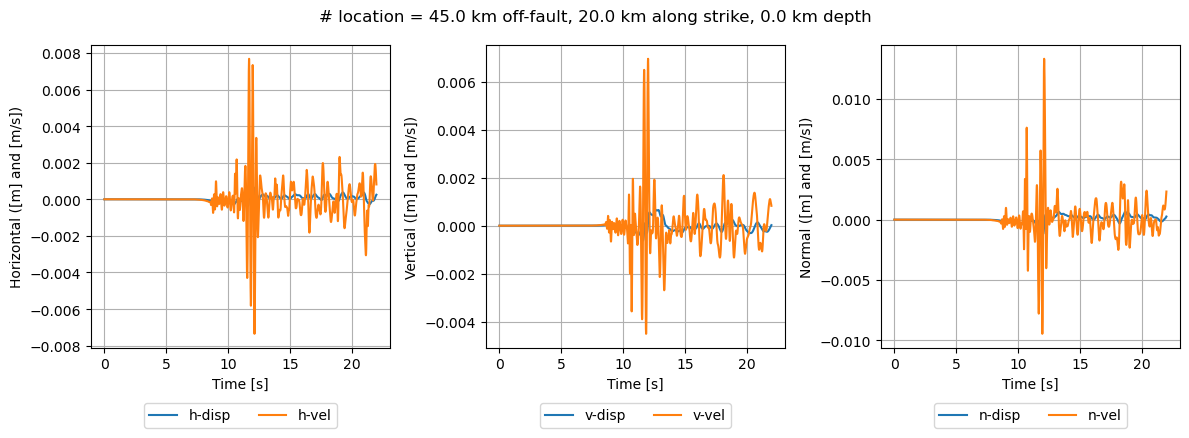

In [37]:
# Create figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))
fig.suptitle(title)
# Plot xx, yy, zz, xy, yz, xz on ax1
ax1.plot(df["t"], df["h-disp"], label="h-disp")
ax1.plot(df["t"], df["h-vel"], label="h-vel")

ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Horizontal ([m] and [m/s])")
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
ax1.grid(True)
# Plot v1, v2, v3 on ax2
ax2.plot(df["t"], df["v-disp"], label="v-disp")
ax2.plot(df["t"], df["v-vel"], label="v-vel")

ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Vertical ([m] and [m/s])")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
ax2.grid(True)
# Plot displacements
ax3.plot(df["t"], df["n-disp"], label="n-disp")
ax3.plot(df["t"], df["n-vel"], label="n-vel")

ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Normal ([m] and [m/s])")
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
ax3.grid(True)
# Adjust layout and display
plt.tight_layout()
#if len(f.split('-')) > 1:
#    fig.savefig(output_folder + "/" + f[-22:-4] + ".png", dpi=300)
#else:
#    fig.savefig(output_folder + "/" + f[-21:-4] + ".png", dpi=300)
plt.show()

## Plot all on-fault receivers - first comparison

### Horizontal-Vertical-NormalStress (not recommended)

x1 = 4000.0, x2 = -2.2743893359617954e-15, x3 = -8.488136558002192e-15


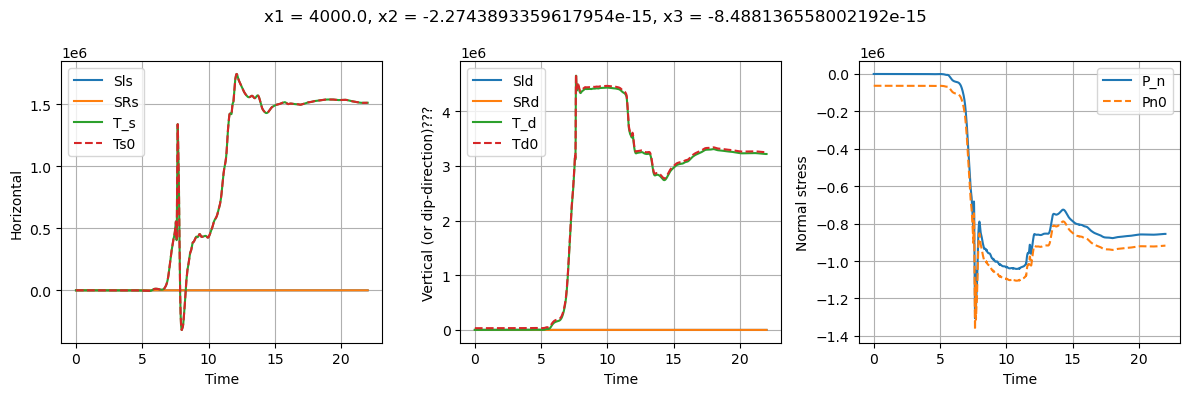

x1 = -1.0373797324966073e-26, x2 = 11591.109915468818, x3 = -3105.828541230252


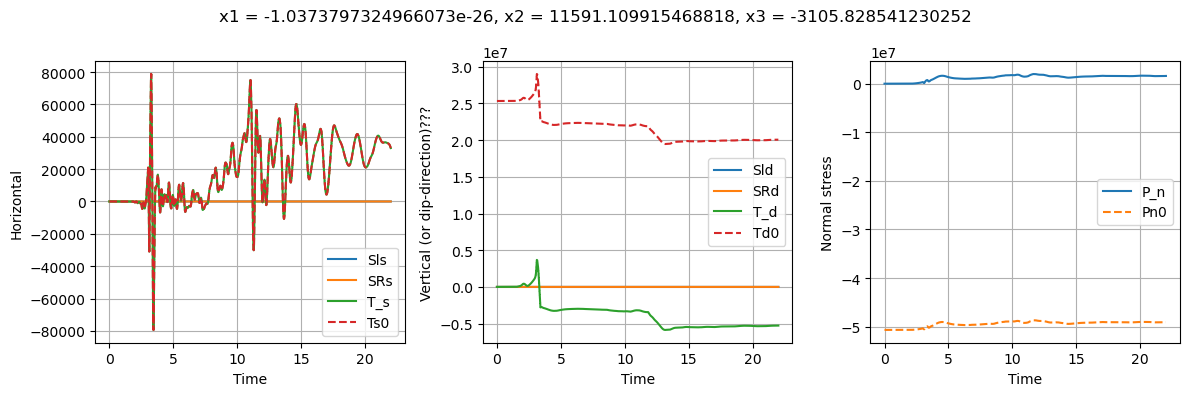

x1 = 4000.0, x2 = 11591.109915468816, x3 = -3105.828541230253


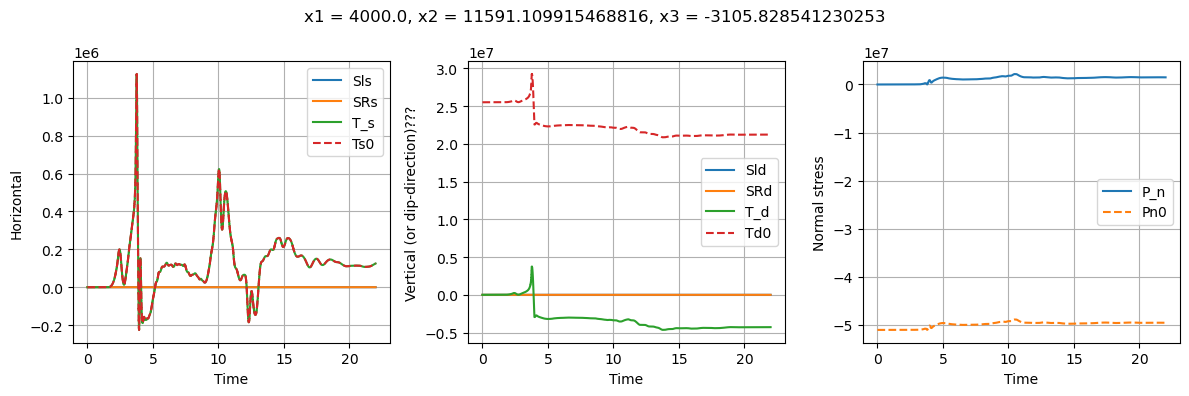

x1 = 12000.0, x2 = 17386.66487320323, x3 = -4658.742811845379


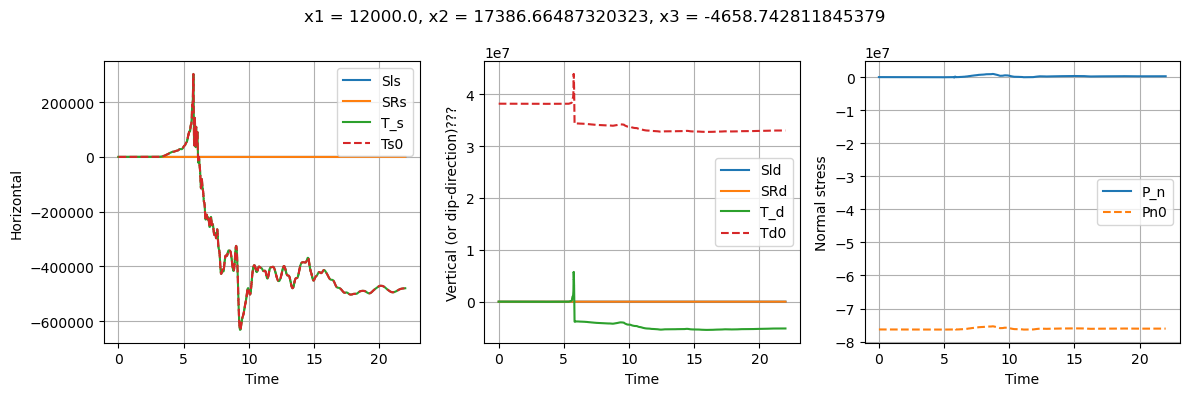

x1 = 7.386575022731597e-28, x2 = 2897.777478867204, x3 = -776.4571353075632


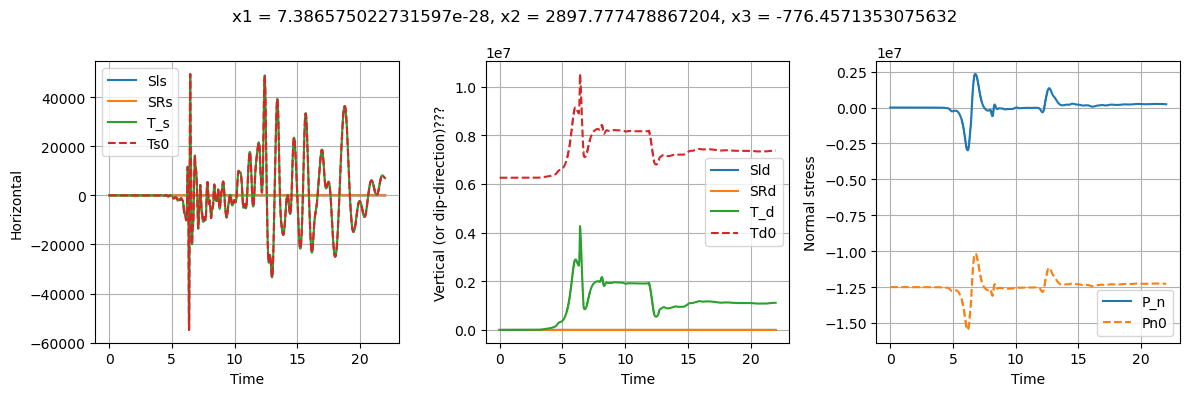

x1 = 8000.0, x2 = 17386.66487320323, x3 = -4658.742811845378


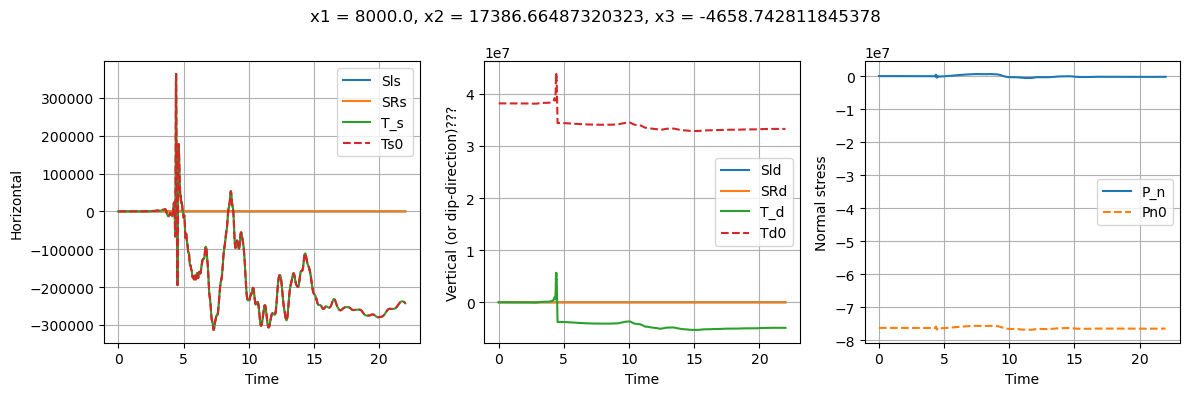

x1 = 4000.0, x2 = 2897.777478867204, x3 = -776.4571353075635


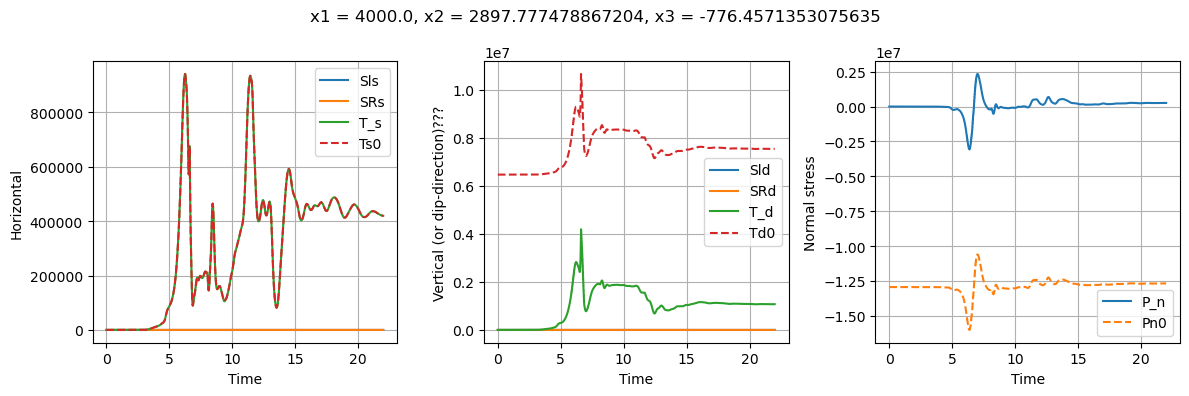

x1 = 4000.0, x2 = 5795.554957734409, x3 = -1552.914270615126


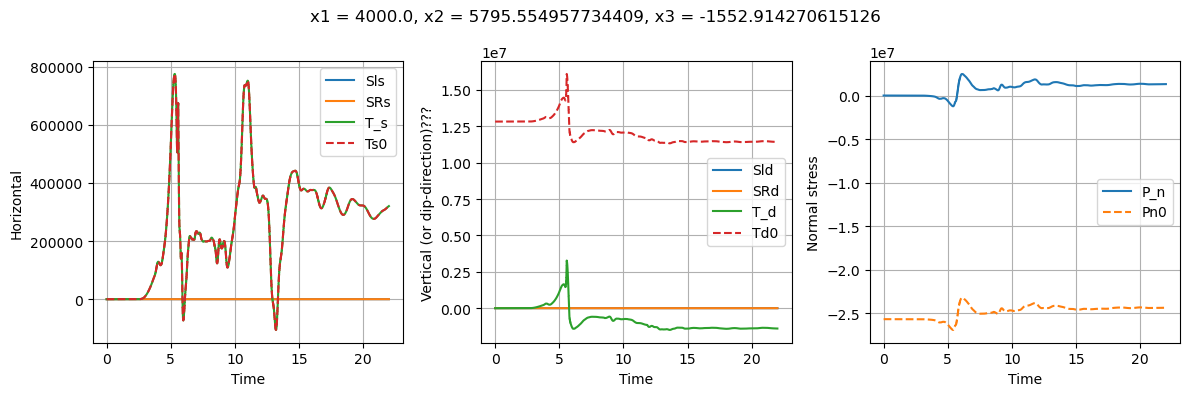

x1 = -3.51483179660596e-27, x2 = 5795.554957734408, x3 = -1552.914270615126


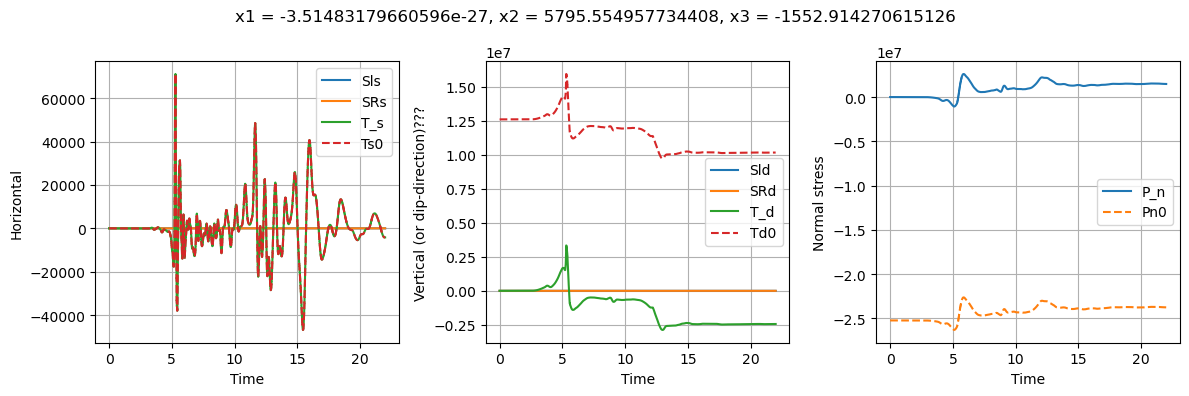

x1 = 8000.0, x2 = 11591.109915468818, x3 = -3105.828541230252


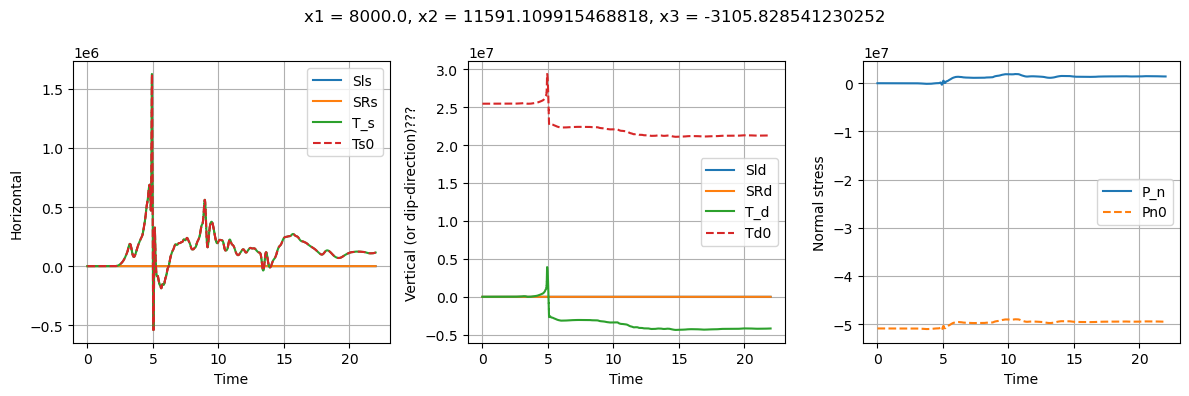

x1 = 1.9041129076110582e-28, x2 = 965.925826289068, x3 = -258.81904510252156


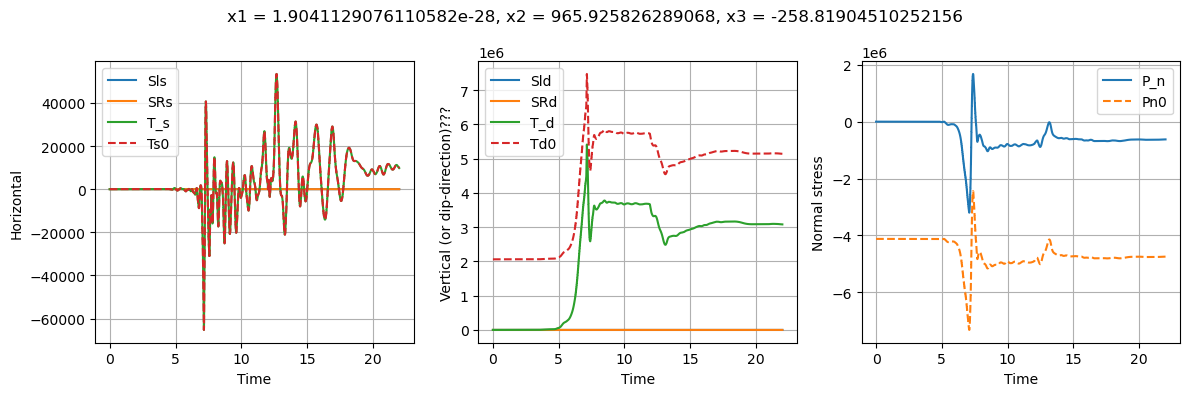

x1 = 1.0331717093853678e-26, x2 = 23182.219830937636, x3 = -6211.657082460504


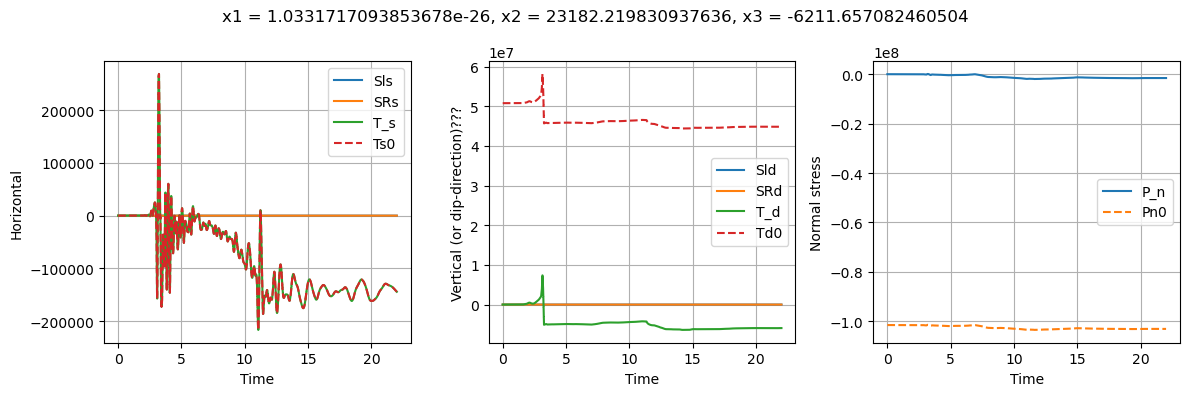

x1 = 8000.0, x2 = 0.0, x3 = -0.0


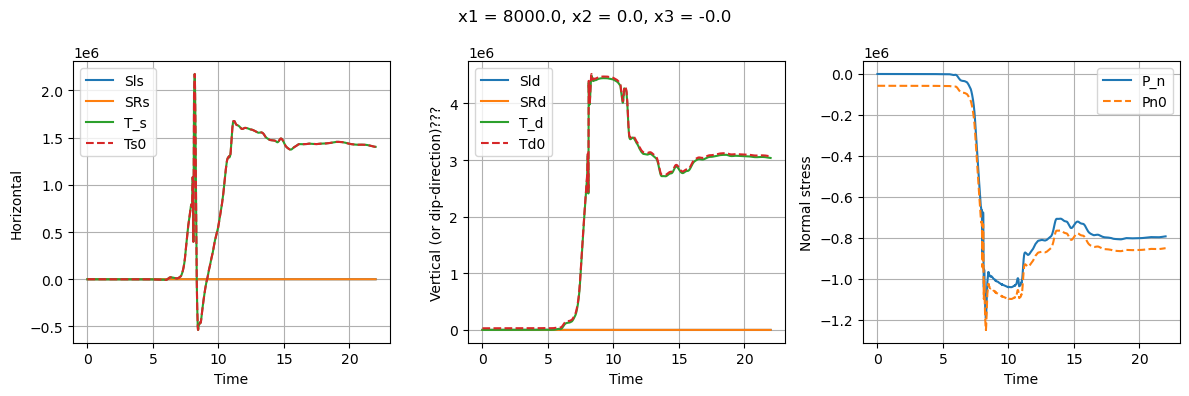

x1 = 12000.0, x2 = -4.8197147319170696e-15, x3 = -1.7987420257502597e-14


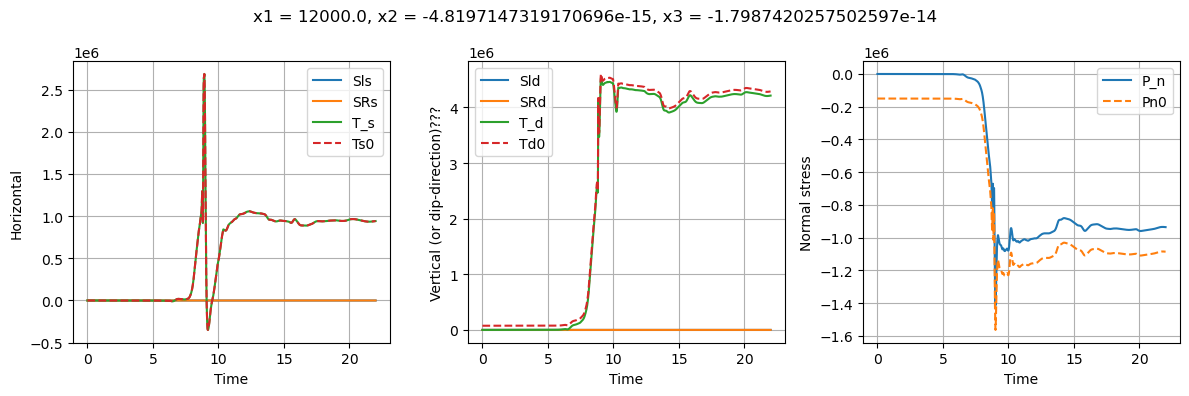

x1 = 0.0, x2 = 0.0, x3 = -0.0


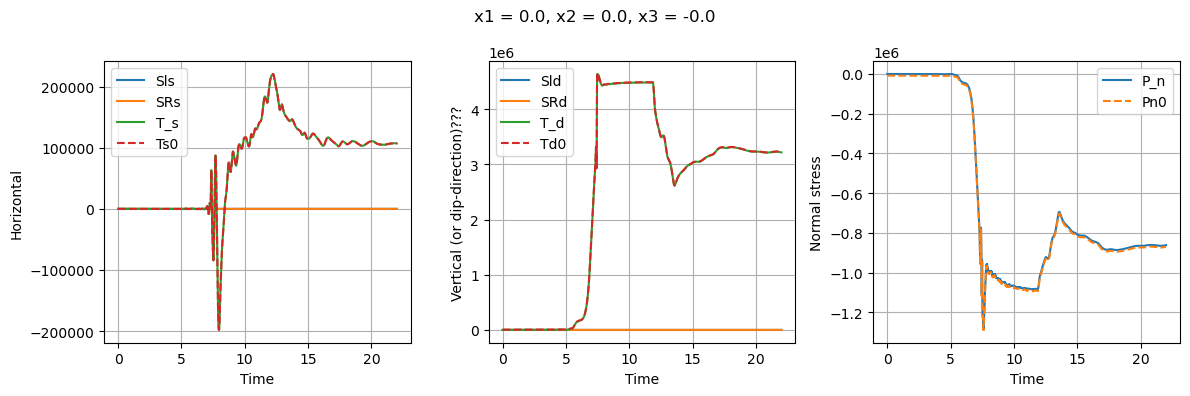

x1 = 8000.0, x2 = 5795.554957734409, x3 = -1552.914270615126


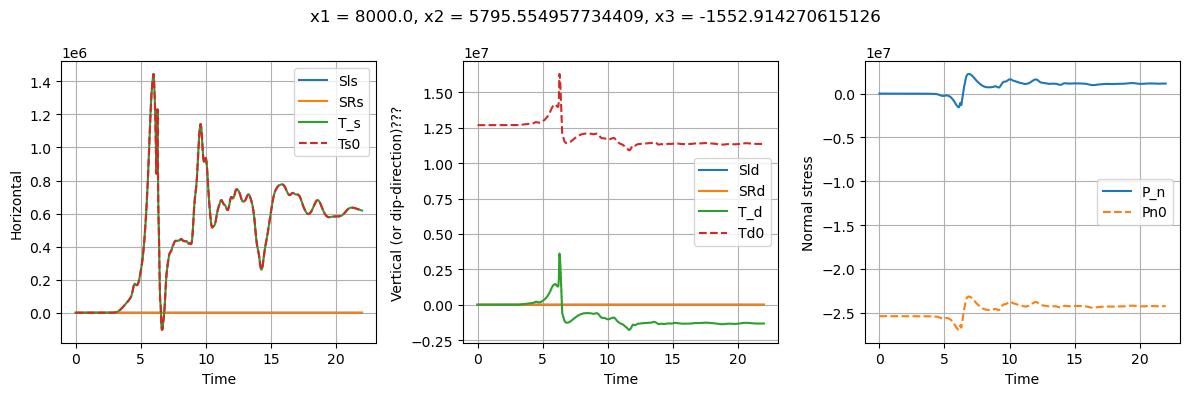

x1 = 12000.0, x2 = 5795.554957734408, x3 = -1552.9142706151265


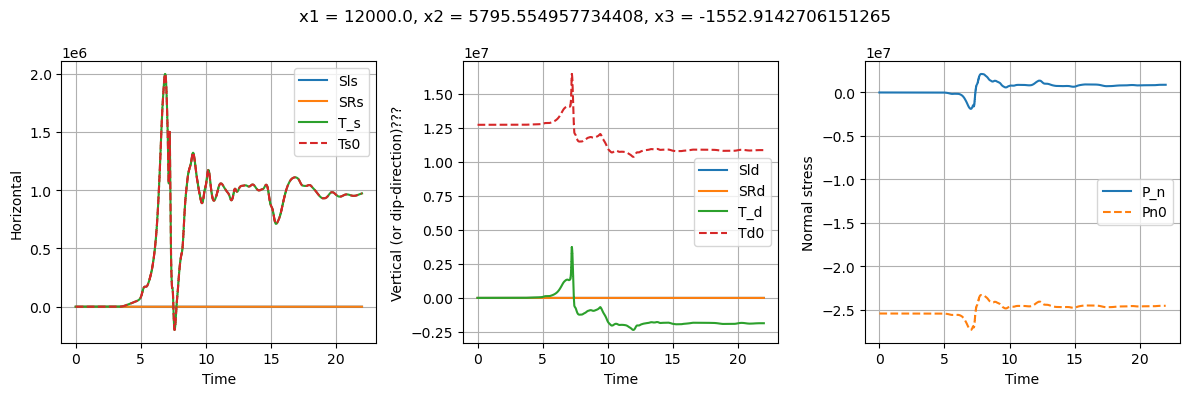

x1 = 4000.0, x2 = 17386.66487320323, x3 = -4658.742811845378


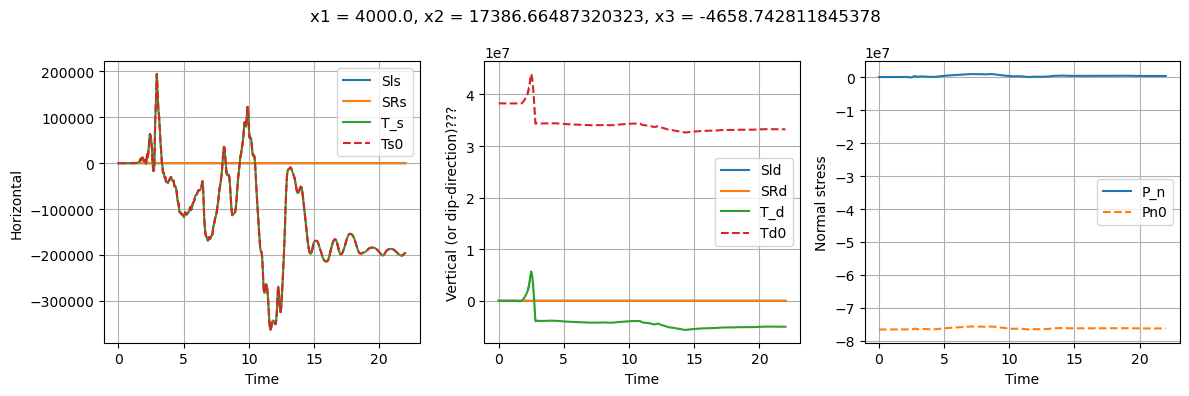

x1 = -1.6673258309716692e-26, x2 = 17386.66487320323, x3 = -4658.74281184538


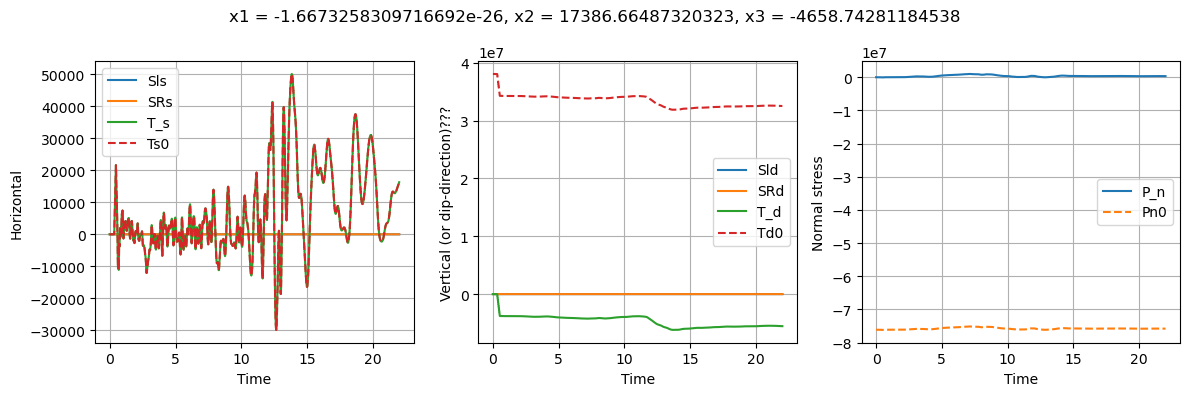

x1 = 12000.0, x2 = 2897.777478867204, x3 = -776.4571353075632


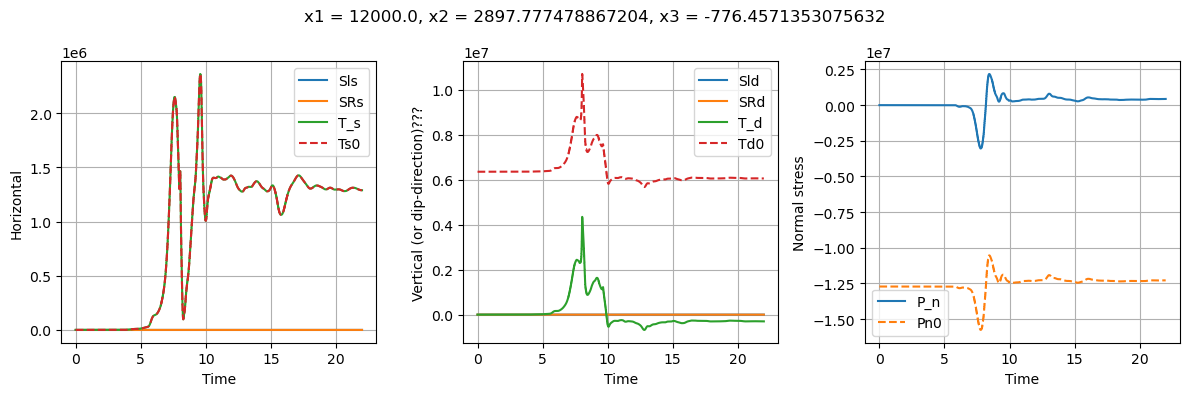

x1 = 8000.0, x2 = 2897.777478867204, x3 = -776.4571353075632


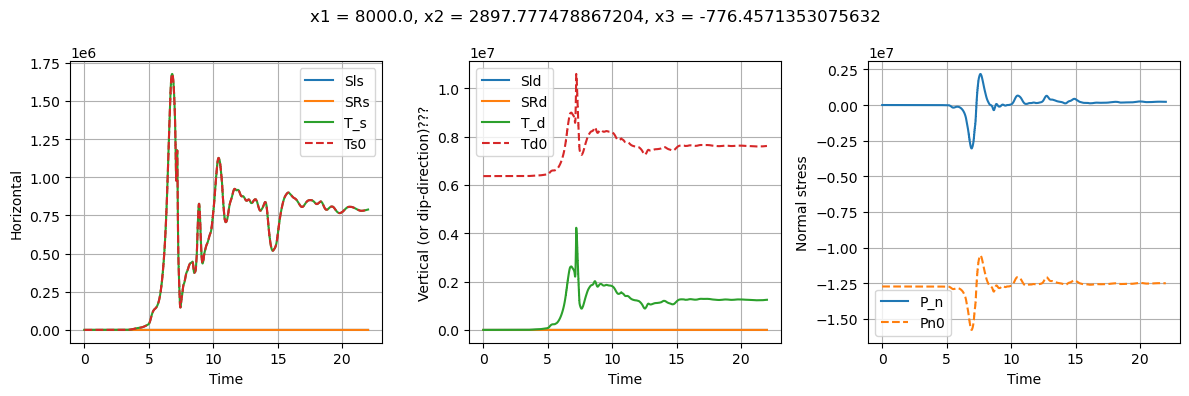

x1 = 12000.0, x2 = 11591.109915468816, x3 = -3105.828541230253


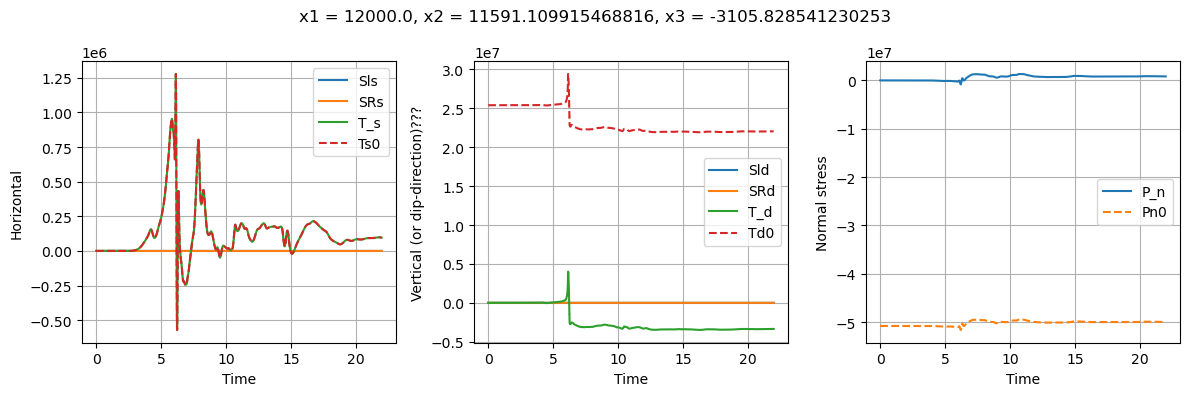

In [5]:
VARIABLES = "Time" ,"SRs" ,"SRd" ,"T_s" ,"T_d" ,"P_n" ,"u_n" ,"Mud" ,"StV" ,"Ts0" ,"Td0" ,"Pn0" ,"Sls" ,"Sld" ,"Vr" ,"ASl" ,"PSR" ,"RT" ,"DS" ,"P_f" ,"Tmp"
filenames = "tpv36-faultreceiver*.dat"

files = glob.glob(os.path.join("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3", filenames))
for f in files:
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]
    x2 = coords[2][1]
    x3 = coords[2][2]
    df = {"x1": [x1], "x2": [x2], "x3": [x3]}
    title = "x1 = {}, x2 = {}, x3 = {}".format(x1, x2, x3)
    print(title)

    df = pd.read_csv(f, skiprows=5, sep="\s+", names=VARIABLES)
    #df["v3"] *= -1 # vertical component needs to be flipped
    dt = df["Time"][1] - df["Time"][0]
    
    # Create figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(title)

    # Plot horizontal
    ax1.plot(df["Time"], df["Sls"], label="Sls")
    ax1.plot(df["Time"], df["SRs"], label="SRs")
    ax1.plot(df["Time"], df["T_s"], label="T_s")
    ax1.plot(df["Time"], df["Ts0"], label="Ts0", linestyle="dashed")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Horizontal")
    ax1.legend()
    ax1.grid(True)

    # Plot vertical
    ax2.plot(df["Time"], df["Sld"], label="Sld")
    ax2.plot(df["Time"], df["SRd"], label="SRd")
    ax2.plot(df["Time"], df["T_d"], label="T_d") 
    ax2.plot(df["Time"], df["Td0"], label="Td0", linestyle="dashed") 
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Vertical (or dip-direction)???")
    ax2.legend()
    ax2.grid(True)

    # Plot normal stress
    ax3.plot(df["Time"], df["P_n"], label="P_n")
    ax3.plot(df["Time"], df["Pn0"], label="Pn0", linestyle="dashed")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Normal stress")
    ax3.legend()
    ax3.grid(True)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

### Slip-SlipRate-Stress (recommended)

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00008-00000.dat
x1 = 4000.0, x2 = -2.2743893359617954e-15, x3 = -8.488136558002192e-15


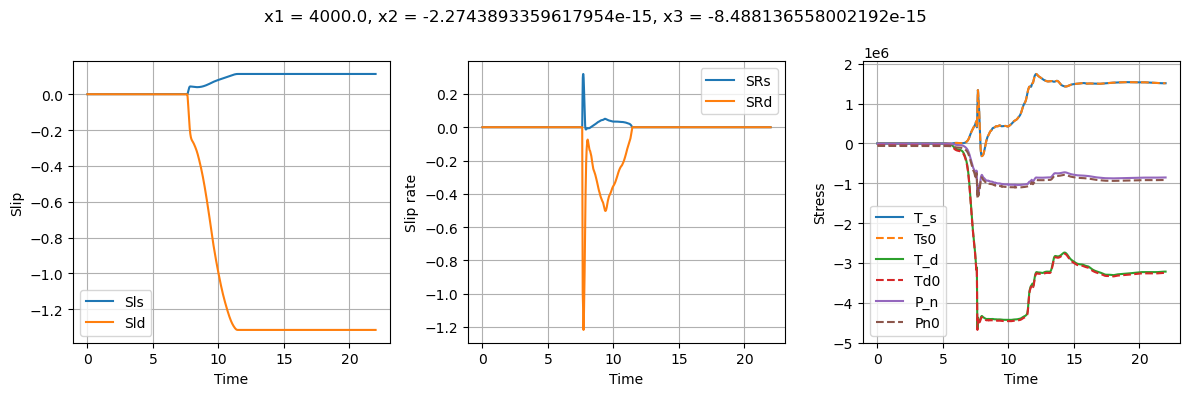

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00005-00000.dat
x1 = -1.0373797324966073e-26, x2 = 11591.109915468818, x3 = -3105.828541230252


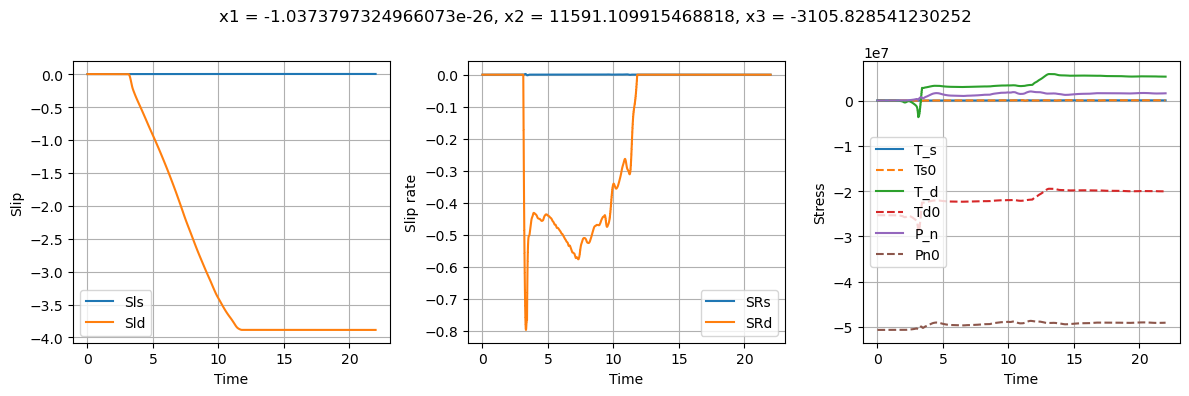

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00011-00000.dat
x1 = 4000.0, x2 = 11591.109915468816, x3 = -3105.828541230253


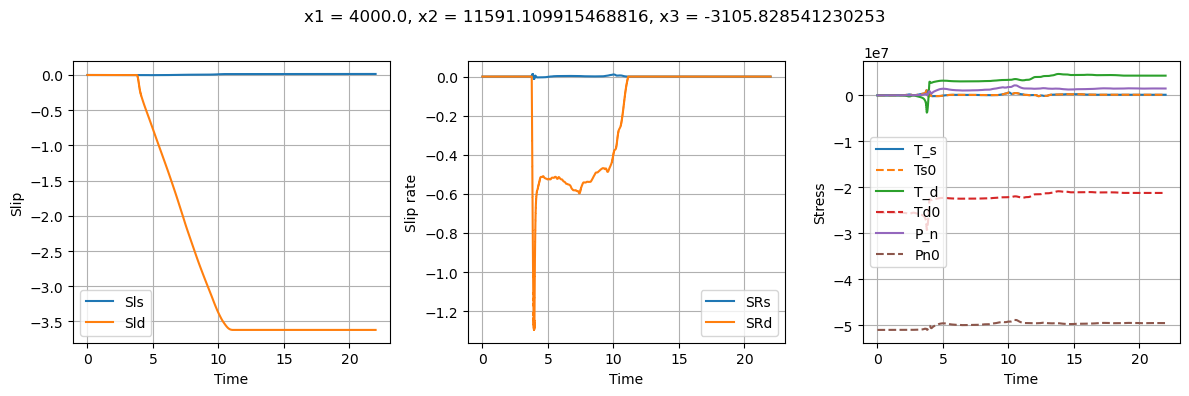

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00022-00000.dat
x1 = 12000.0, x2 = 17386.66487320323, x3 = -4658.742811845379


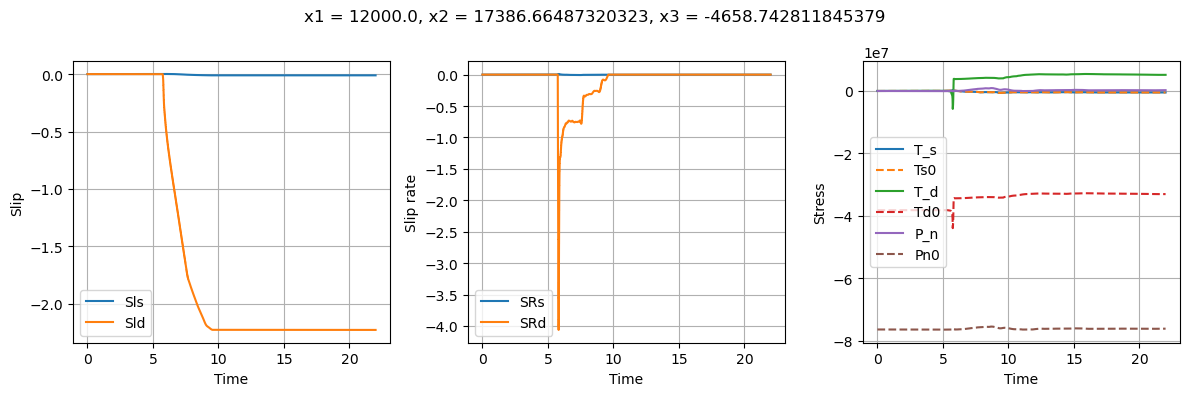

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00003-00000.dat
x1 = 7.386575022731597e-28, x2 = 2897.777478867204, x3 = -776.4571353075632


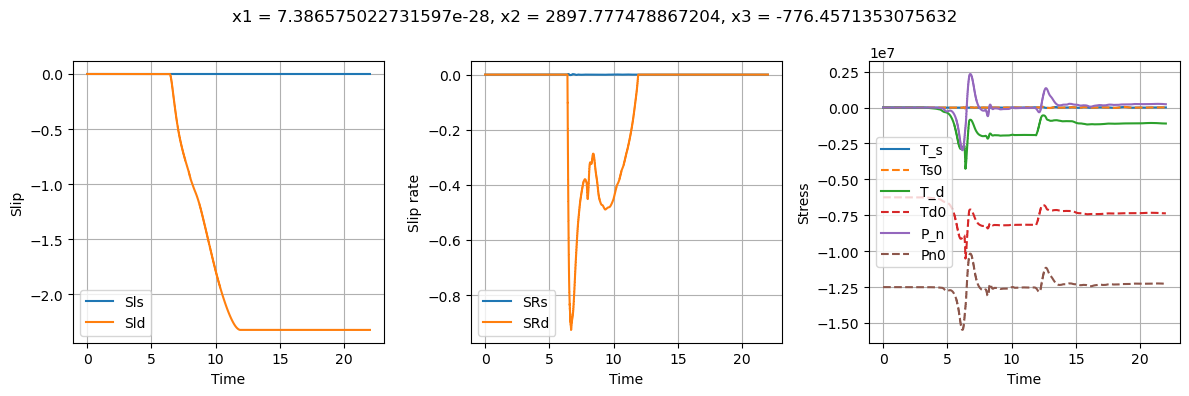

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00017-00000.dat
x1 = 8000.0, x2 = 17386.66487320323, x3 = -4658.742811845378


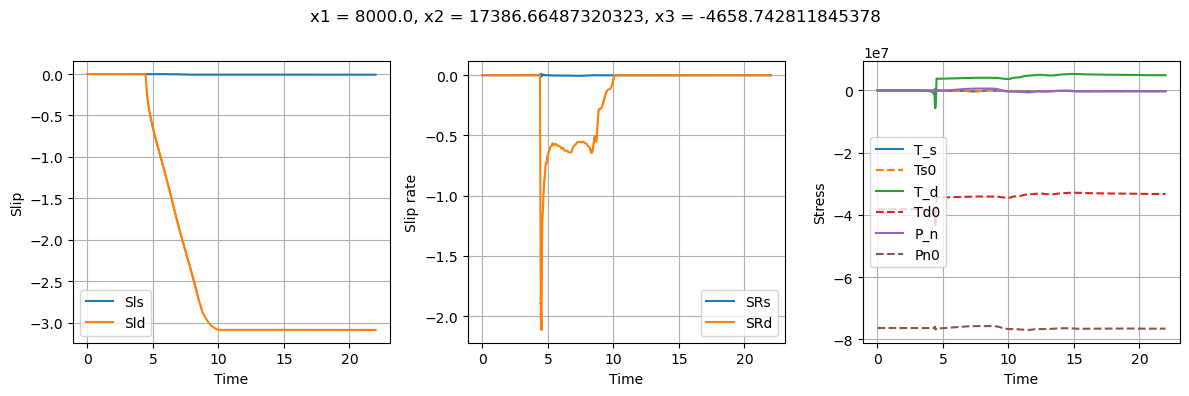

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00009-00000.dat
x1 = 4000.0, x2 = 2897.777478867204, x3 = -776.4571353075635


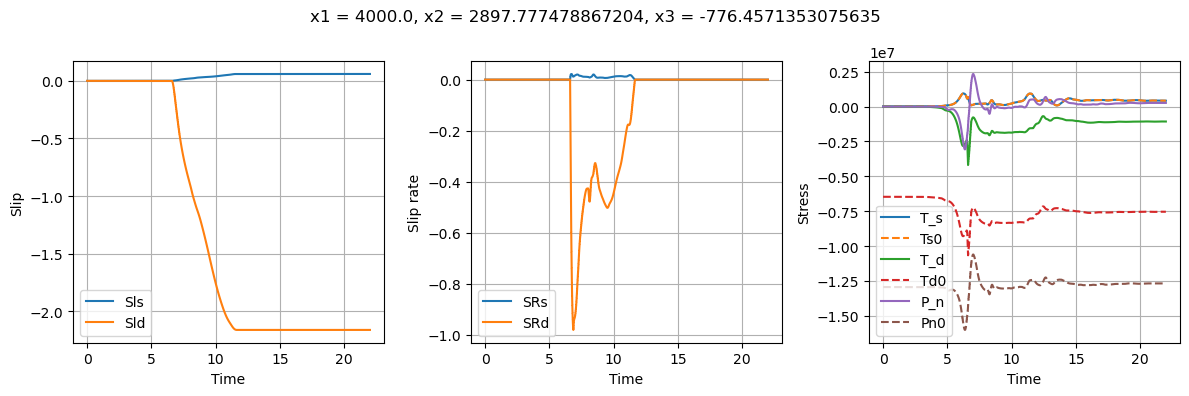

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00010-00000.dat
x1 = 4000.0, x2 = 5795.554957734409, x3 = -1552.914270615126


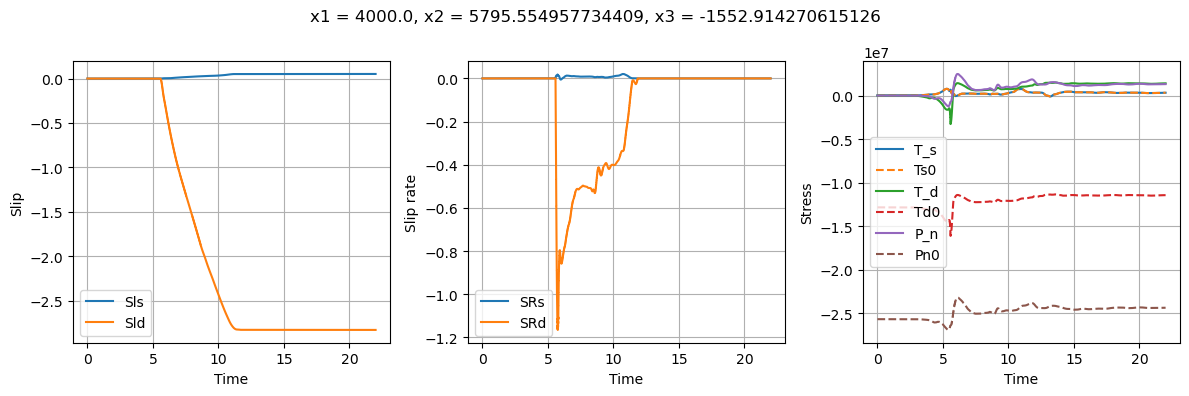

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00004-00000.dat
x1 = -3.51483179660596e-27, x2 = 5795.554957734408, x3 = -1552.914270615126


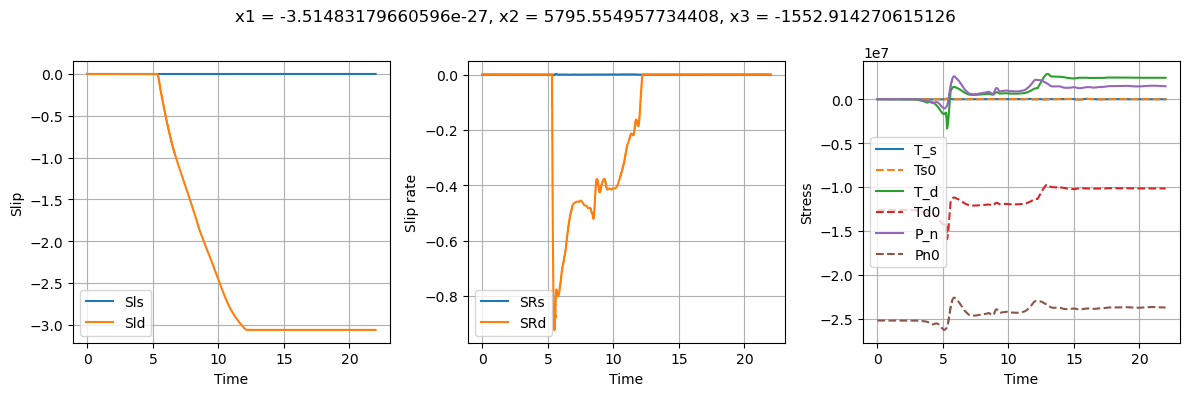

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00016-00000.dat
x1 = 8000.0, x2 = 11591.109915468818, x3 = -3105.828541230252


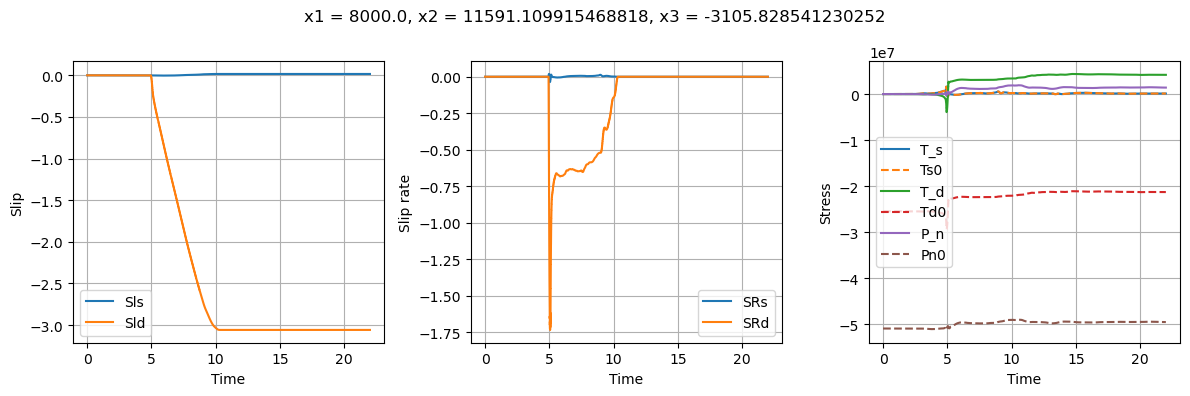

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00002-00000.dat
x1 = 1.9041129076110582e-28, x2 = 965.925826289068, x3 = -258.81904510252156


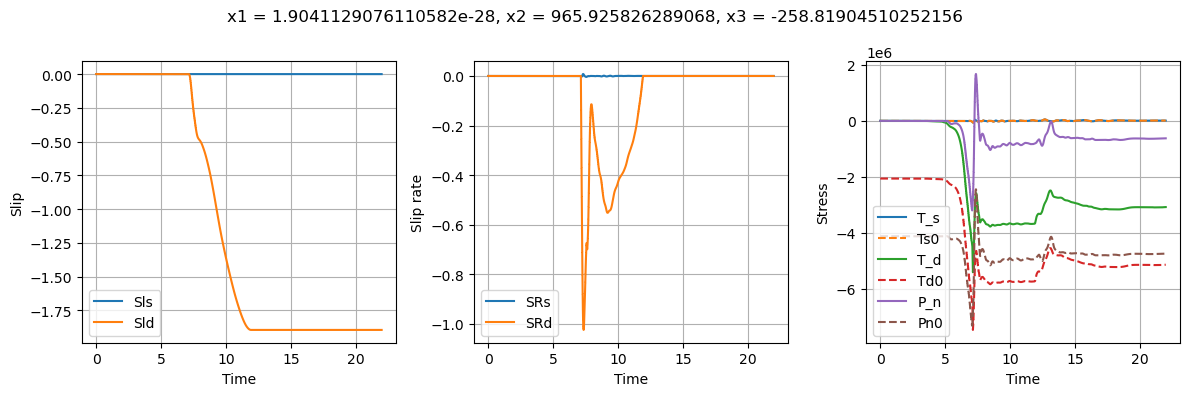

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00007-00000.dat
x1 = 1.0331717093853678e-26, x2 = 23182.219830937636, x3 = -6211.657082460504


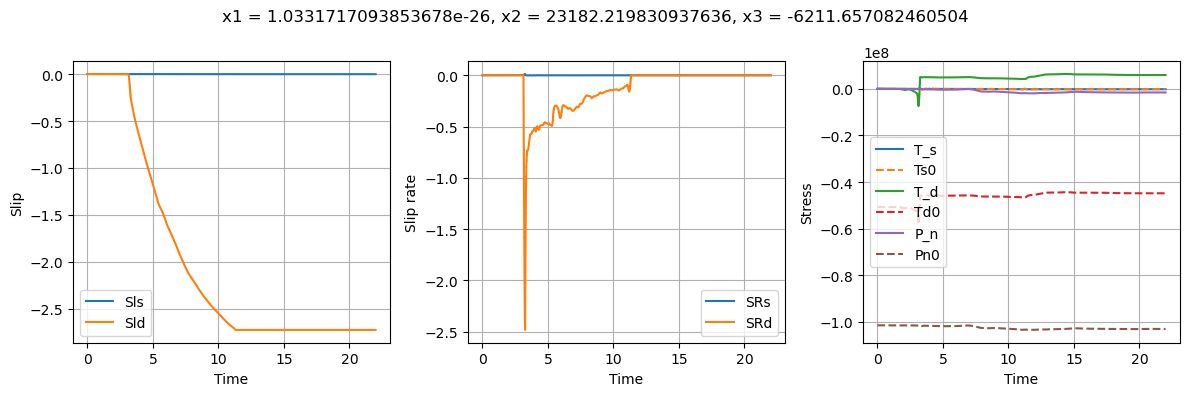

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00013-00000.dat
x1 = 8000.0, x2 = 0.0, x3 = -0.0


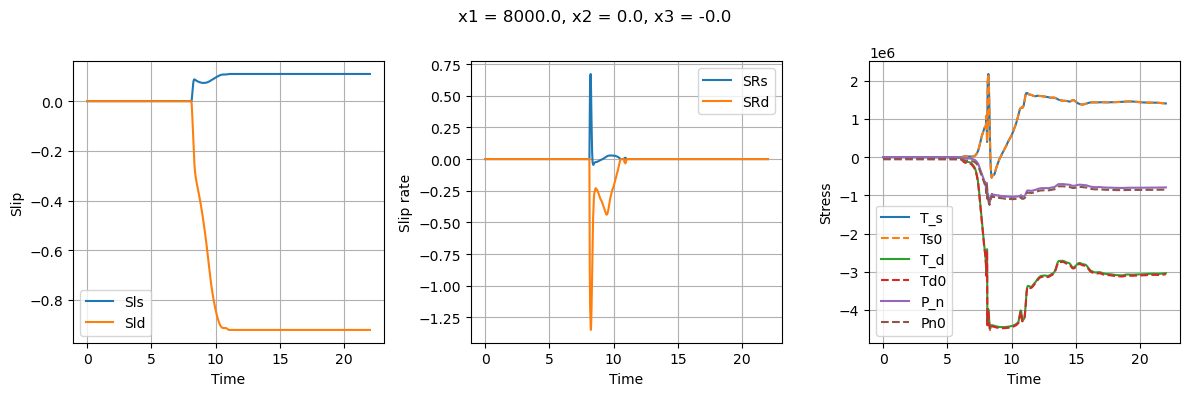

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00018-00000.dat
x1 = 12000.0, x2 = -4.8197147319170696e-15, x3 = -1.7987420257502597e-14


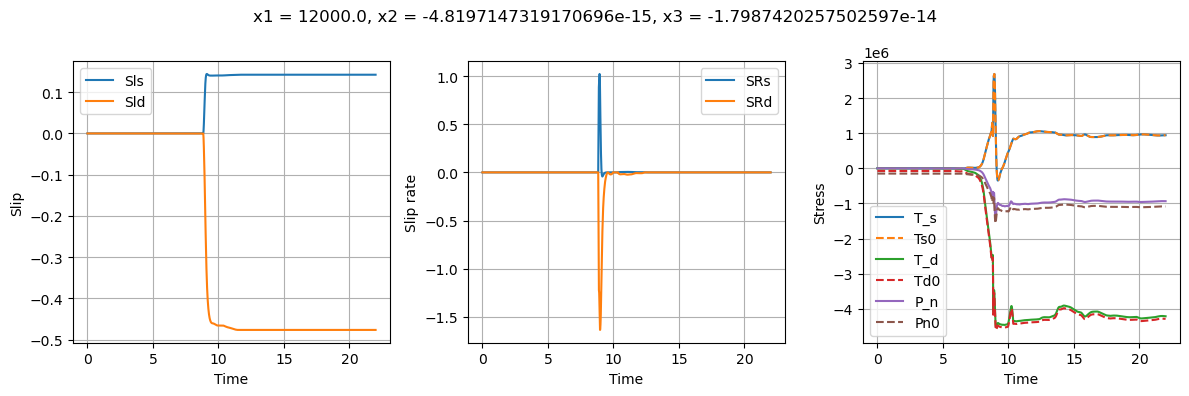

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00001-00000.dat
x1 = 0.0, x2 = 0.0, x3 = -0.0


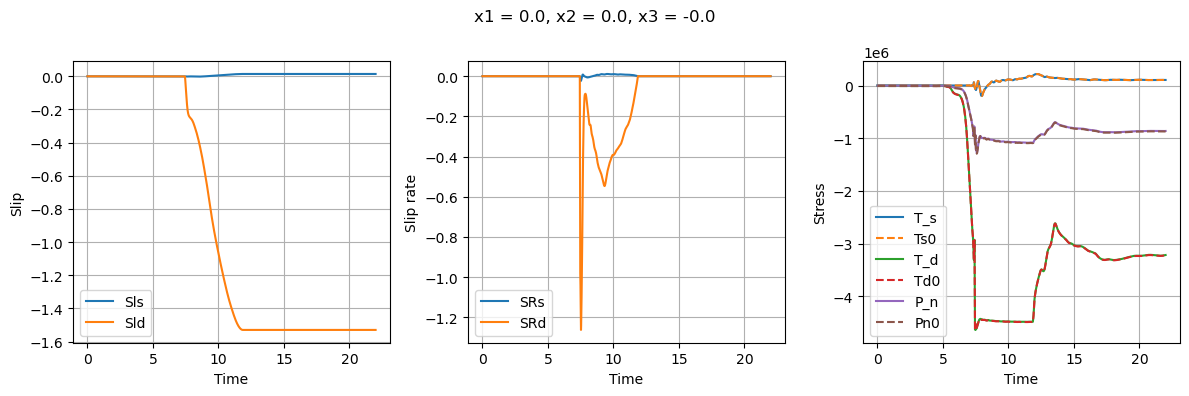

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00015-00000.dat
x1 = 8000.0, x2 = 5795.554957734409, x3 = -1552.914270615126


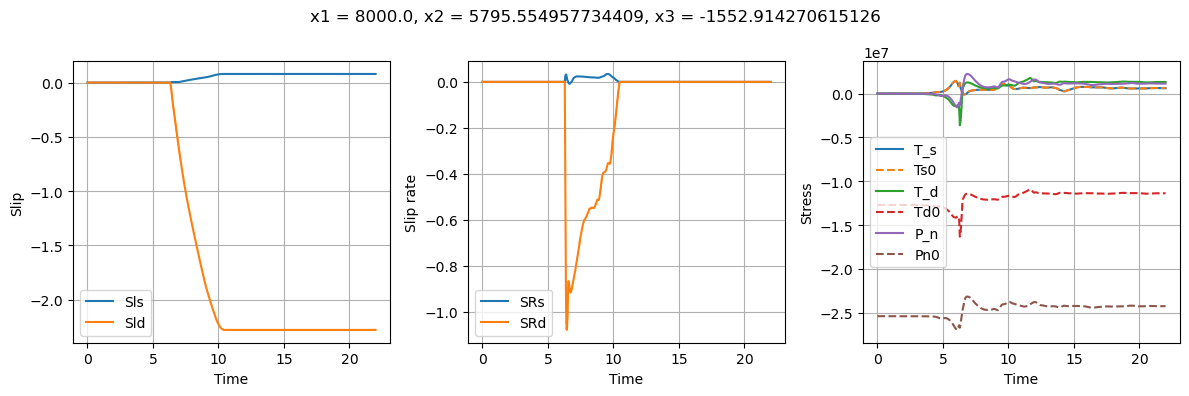

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00020-00000.dat
x1 = 12000.0, x2 = 5795.554957734408, x3 = -1552.9142706151265


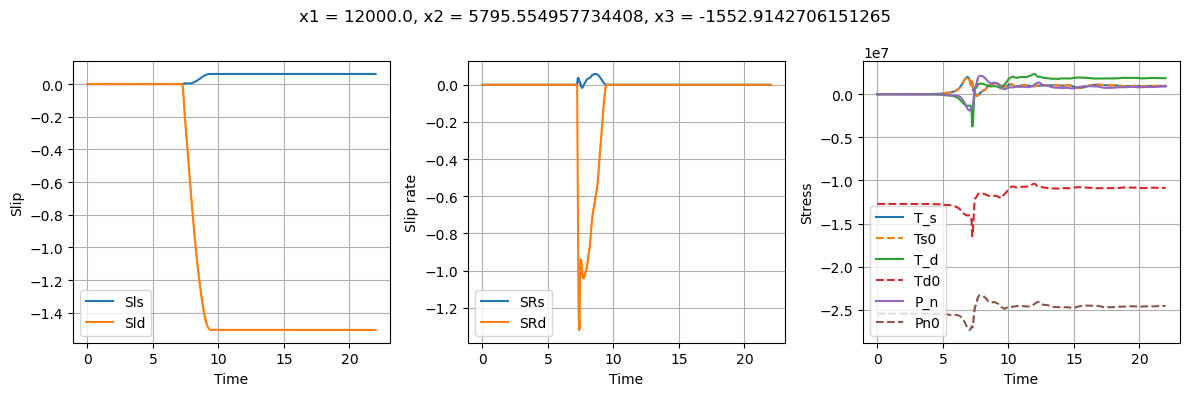

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00012-00000.dat
x1 = 4000.0, x2 = 17386.66487320323, x3 = -4658.742811845378


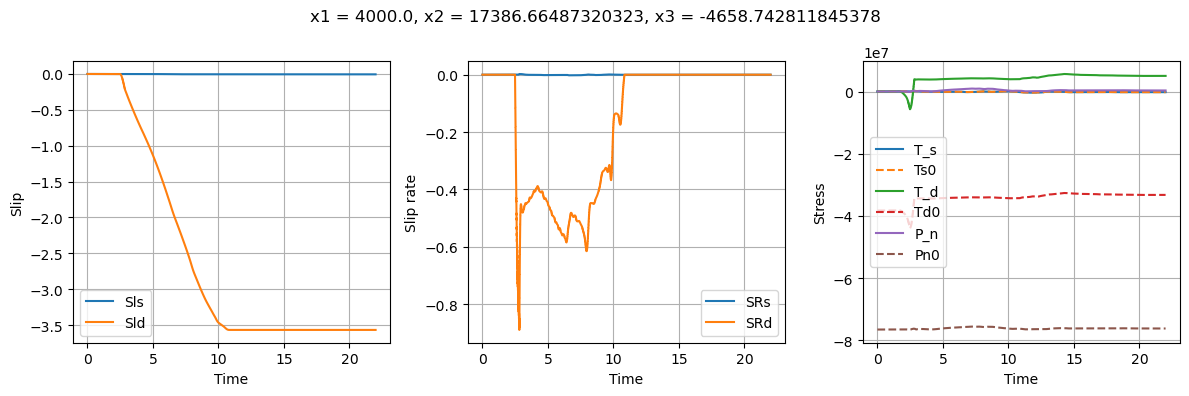

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00006-00000.dat
x1 = -1.6673258309716692e-26, x2 = 17386.66487320323, x3 = -4658.74281184538


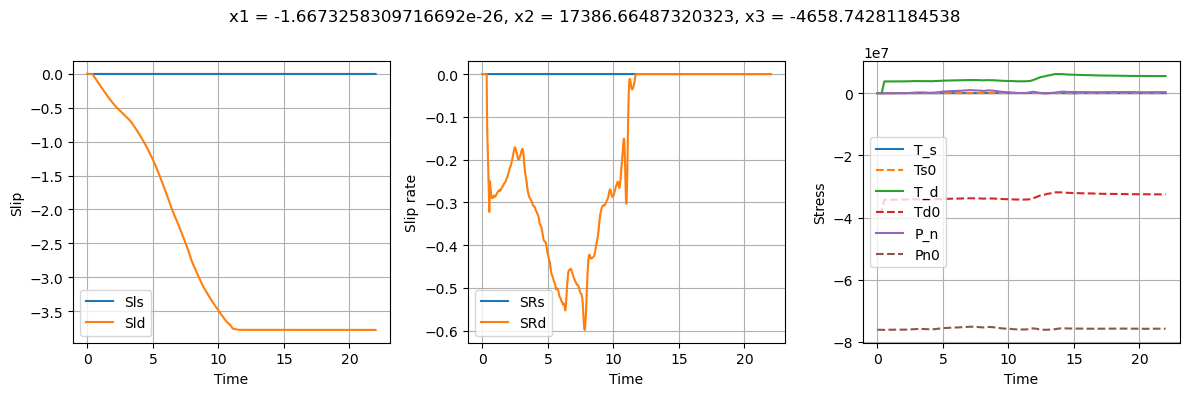

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00019-00000.dat
x1 = 12000.0, x2 = 2897.777478867204, x3 = -776.4571353075632


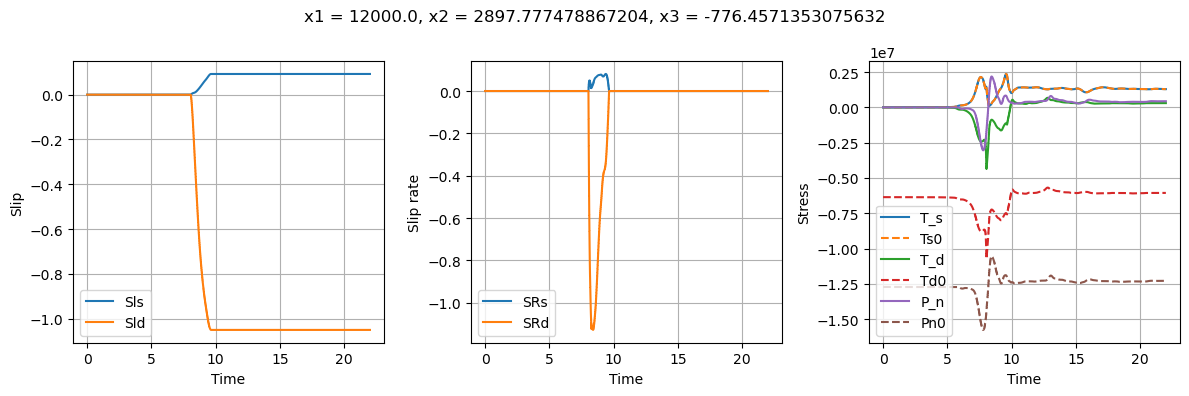

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00014-00000.dat
x1 = 8000.0, x2 = 2897.777478867204, x3 = -776.4571353075632


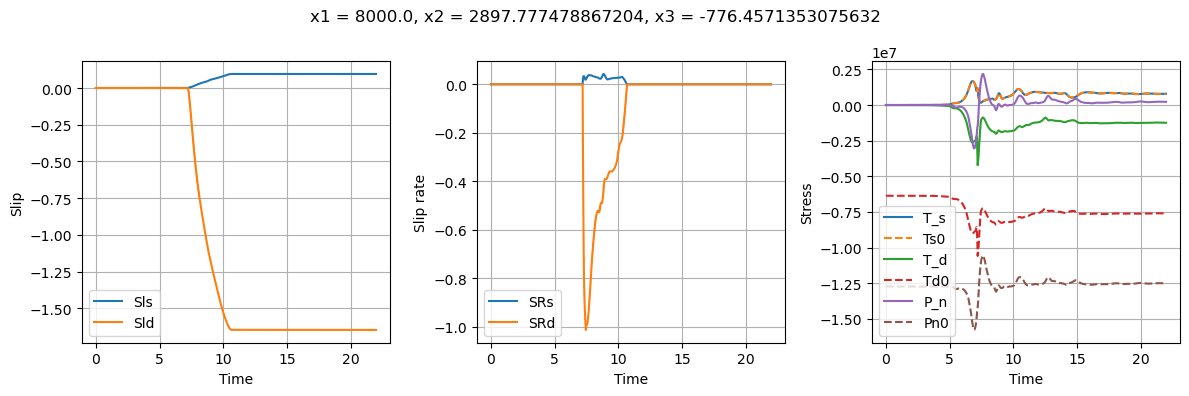

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3/tpv36-faultreceiver-00021-00000.dat
x1 = 12000.0, x2 = 11591.109915468816, x3 = -3105.828541230253


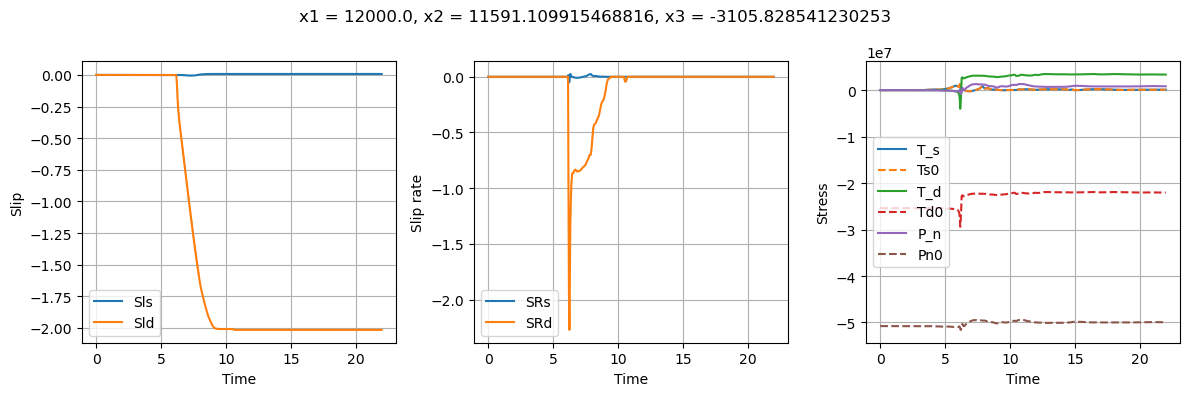

In [6]:
VARIABLES = "Time" ,"SRs" ,"SRd" ,"T_s" ,"T_d" ,"P_n" ,"u_n" ,"Mud" ,"StV" ,"Ts0" ,"Td0" ,"Pn0" ,"Sls" ,"Sld" ,"Vr" ,"ASl" ,"PSR" ,"RT" ,"DS" ,"P_f" ,"Tmp"
filenames = "tpv36-faultreceiver*.dat"

files = glob.glob(os.path.join("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/output_v3", filenames))
for f in files:
    print(f)
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]
    x2 = coords[2][1]
    x3 = coords[2][2]
    df = {"x1": [x1], "x2": [x2], "x3": [x3]}
    title = "x1 = {}, x2 = {}, x3 = {}".format(x1, x2, x3)
    print(title)

    df = pd.read_csv(f, skiprows=5, sep="\s+", names=VARIABLES)
    df["Sld"] *= -1 # vertical component needs to be flipped
    df["SRd"] *= -1 
    df["Td0"] *= -1
    df["T_d"] *= -1
    dt = df["Time"][1] - df["Time"][0]
    
    # Create figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(title)

    # Plot slip
    ax1.plot(df["Time"], df["Sls"], label="Sls")
    ax1.plot(df["Time"], df["Sld"], label="Sld")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Slip")
    ax1.legend()
    ax1.grid(True)

    # Plot slip rate
    ax2.plot(df["Time"], df["SRs"], label="SRs")
    ax2.plot(df["Time"], df["SRd"], label="SRd")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Slip rate")
    ax2.legend()
    ax2.grid(True)

    # Plot stress
    ax3.plot(df["Time"], df["T_s"], label="T_s")
    ax3.plot(df["Time"], df["Ts0"], label="Ts0", linestyle="dashed")
    ax3.plot(df["Time"], df["T_d"], label="T_d") 
    ax3.plot(df["Time"], df["Td0"], label="Td0", linestyle="dashed") 
    ax3.plot(df["Time"], df["P_n"], label="P_n")
    ax3.plot(df["Time"], df["Pn0"], label="Pn0", linestyle="dashed")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Stress")
    ax3.legend()
    ax3.grid(True)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

## Prepare on-fault receivers for TPV upload

### For loop processing SeisSol receivers (on-fault)

In [10]:
# Folder where the processed receivers will be saved
output_folder = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/"
# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

VARIABLES = "Time" ,"SRs" ,"SRd" ,"T_s" ,"T_d" ,"P_n" ,"u_n" ,"Mud" ,"StV" ,"Ts0" ,"Td0" ,"Pn0" ,"Sls" ,"Sld" ,"Vr" ,"ASl" ,"PSR" ,"RT" ,"DS" ,"P_f" ,"Tmp"
filenames = "*-faultreceiver*.dat"

files = glob.glob(os.path.join("/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/tpv36_branch_Zihua_v1/", filenames))
for f in files:
    # Coordinates 
    coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
    x1 = coords[2][0]/1e3 # to km
    x2 = coords[2][1]/1e3
    x3 = coords[2][2]/1e3
    w = x3 / np.sin(15*np.pi / 180) * -1
    
    file = "faultst{:02d}0dp{:02d}0.csv".format(int(x1),int(w))
    print("\nProcessing: ",file)
    print("Location = {:2.1f} km off-fault, {:2.1f} km along strike, {:2.1f} km depth".format(x2,x1,x3))
    print("Location = {:2.1f} km along strike, {:2.1f} km along-dip".format(int(x1),int(w)))
    
    # On-fault receiver data
    df = pd.read_csv(f, skiprows=5, sep='\s+', names=VARIABLES)
    df["Sld"] *= -1 # vertical component needs to be flipped
    df["SRd"] *= -1 
    df["Td0"] *= -1e-6 # MPa in SCEC 
    df["T_d"] *= -1e-6 
    df["Ts0"] *= 1e-6 
    df["T_s"] *= 1e-6 
    df["Pn0"] *= 1e-6
    df["P_n"] *= 1e-6 

    # Resampling time of non-uniform fault receiver is necessary to upload to SCEC
    #time_step = df["Time"][1] - df["Time"][0]
    num_time_steps = len(df)
    resampled_time = np.linspace(start=0.0, stop=22.0, num=num_time_steps, endpoint=True)
    df["Time"] = resampled_time
    time_step = df["Time"][1] - df["Time"][0]
    
    print("Time step, length:", time_step, num_time_steps)
    df.drop(columns=["T_s" ,"T_d" ,"P_n" ,"u_n" ,"Mud" ,"StV", "Vr" ,"ASl" ,"PSR" ,"RT" ,"DS" ,"P_f" ,"Tmp"], inplace=True)
    df.rename({"Time": "t", "Sls": "h-slip", "SRs": "h-slip-rate", "Ts0": "h-shear-stress", 
               "Sld": "v-slip", "SRd": "v-slip-rate", "Td0": "v-shear-stress", "Pn0": "n-stress"}, axis=1, inplace=True)
    df = df.loc[:,["t", "h-slip", "h-slip-rate", "h-shear-stress", "v-slip", "v-slip-rate", "v-shear-stress", "n-stress"]] # re-order columns
    tmp_receiver = os.path.join(output_folder, "tmp_receiver.csv")
    receiver = os.path.join(output_folder, file)
    df.to_csv(tmp_receiver, index=False, sep=" ", float_format="%.7e")

    # Content with placeholders for the values
    file_content = """# problem = TPV36
# author = Fabian Kutschera
# date = 2024/09/17
# code = SeisSol
# code_version = TBD
# element_size = 200.0 m (o4)
# time_step = {} (s)
# num_time_steps = {}
# location = {:2.1f} km along strike, {:2.1f} km down-dip
# Column #1 = Time (s)
# Column #2 = horizontal (along-strike) slip (m)
# Column #3 = horizontal (along-strike) slip rate (m/s)
# Column #4 = horizontal (along-strike) shear stress (MPa)
# Column #5 = along-dip slip (m)
# Column #6 = along-dip slip rate (m/s)
# Column #7 = along-dip shear stress (MPa)
# Column #8 = normal stress (MPa)
#
"""
    
    # Format the string 
    formatted_content = file_content.format(time_step, num_time_steps, x1, abs(np.round(w)))
    
    # Full path to the file
    tmp_file = os.path.join(output_folder, "tmp.txt")
    
    # Write the formatted content to the file
    with open(tmp_file, 'w') as file:
        file.write(formatted_content)
    
    !echo "$tmp_file" "$tmp_receiver" "$receiver"
    !cat "$tmp_file" "$tmp_receiver" > "$receiver"
    !rm "$tmp_file" "$tmp_receiver"


Processing:  faultst080dp060.csv
Location = 5.8 km off-fault, 8.0 km along strike, -1.6 km depth
Location = 8.0 km along strike, 6.0 km along-dip
Time step, length: 0.0002380952380952381 92401
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst080dp060.csv

Processing:  faultst000dp000.csv
Location = 0.0 km off-fault, 0.0 km along strike, 0.0 km depth
Location = 0.0 km along strike, 0.0 km along-dip
Time step, length: 0.0002380952380952381 92401
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/tmp.txt /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/tmp_receiver.csv /Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst000dp000.csv

Processing:  faultst080dp120.csv
Location = 11.6

### Plot all processed receivers (on-fault) to compare against TPV results

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst000dp180.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp180.dat


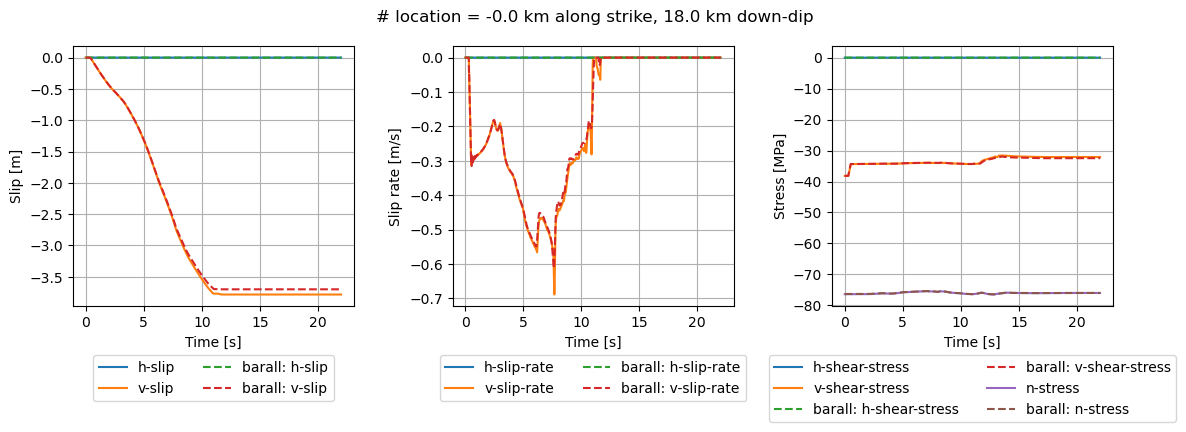

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst120dp030.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp030.dat


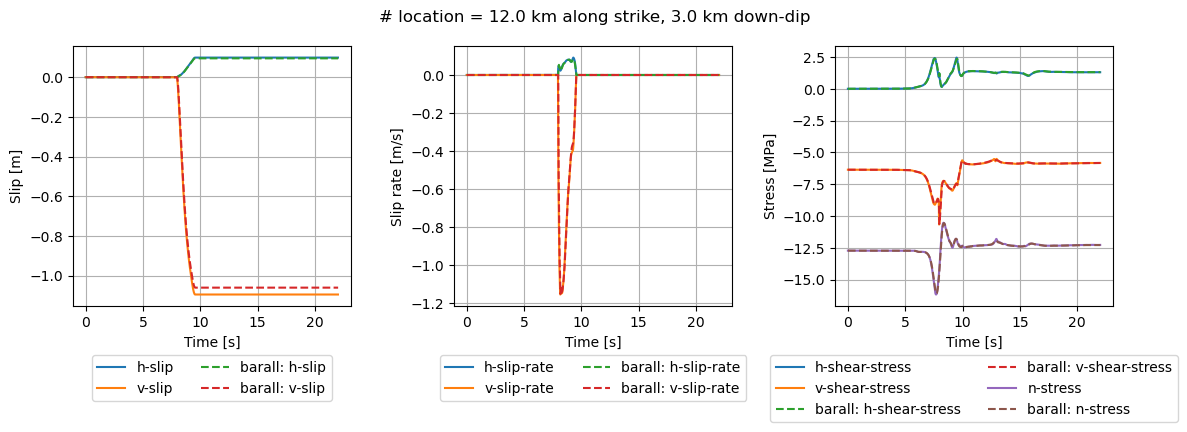

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst000dp030.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp030.dat


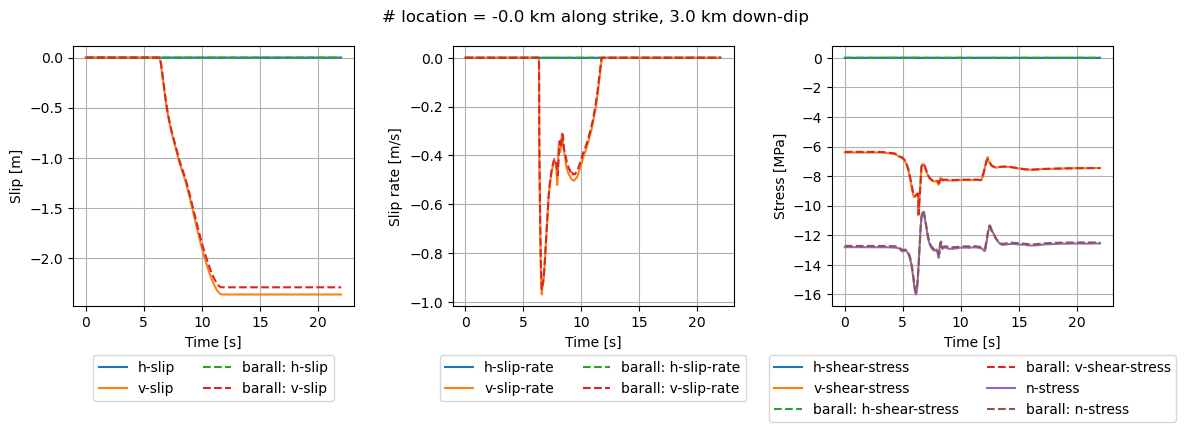

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst040dp060.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp060.dat


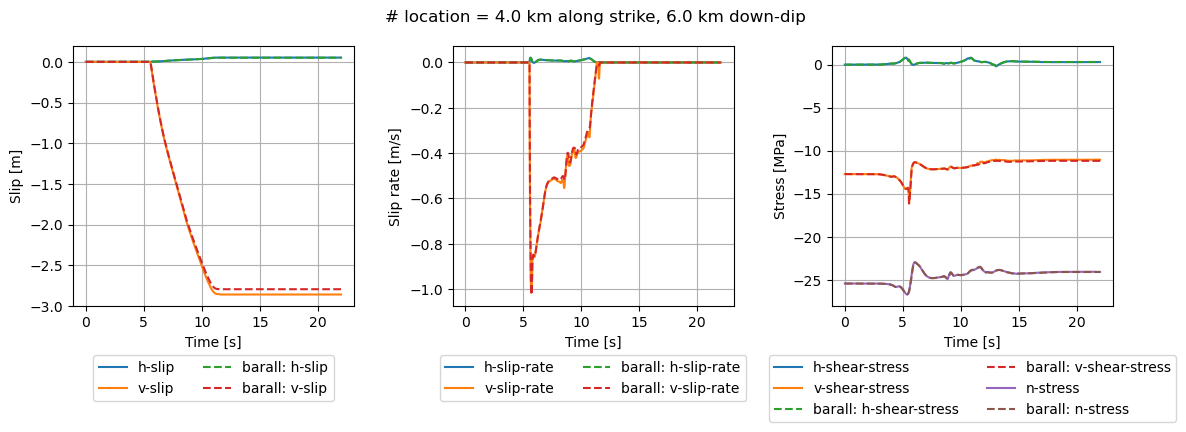

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst120dp180.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp180.dat


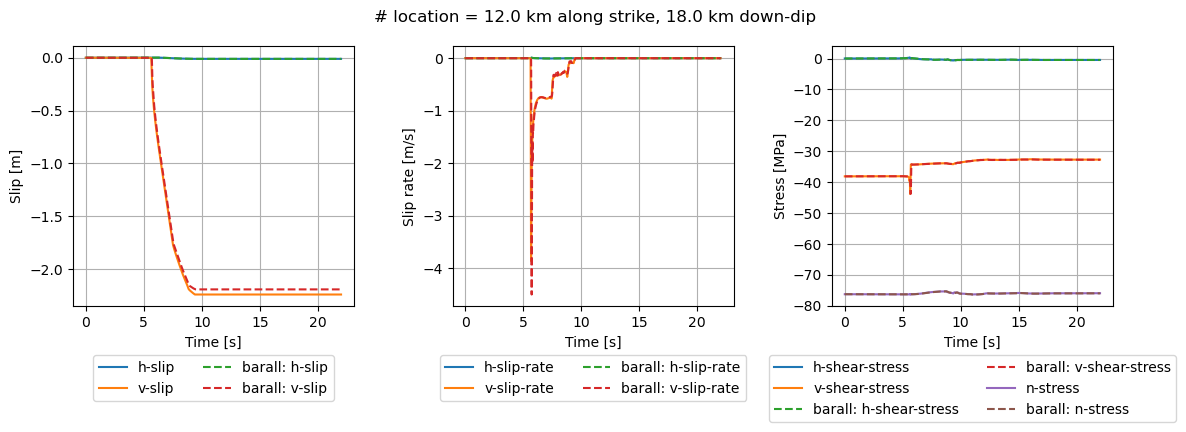

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst080dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp000.dat


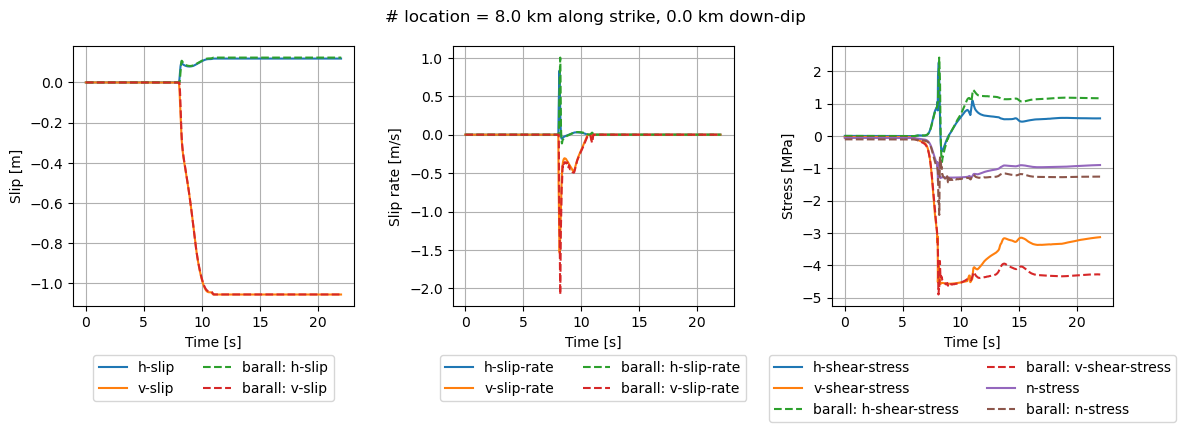

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst000dp120.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp120.dat


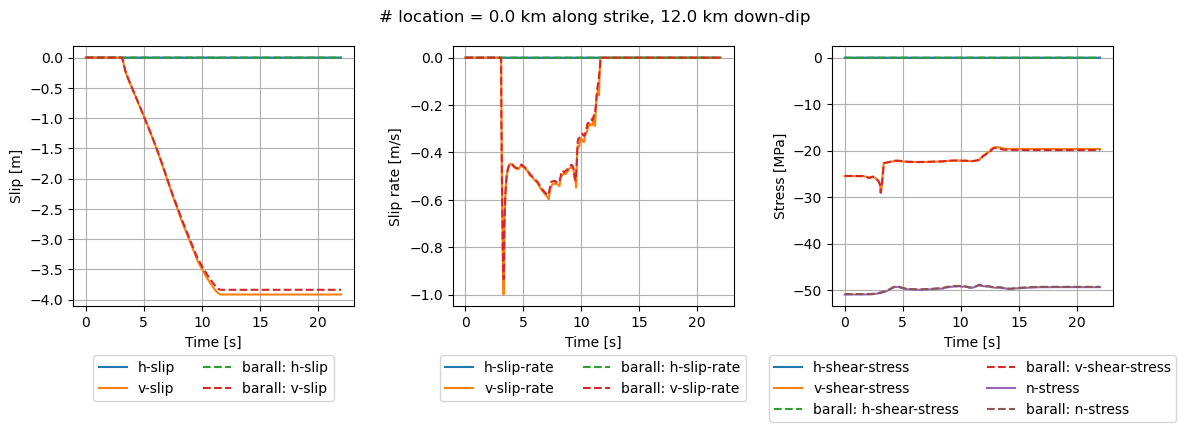

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst000dp240.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp240.dat


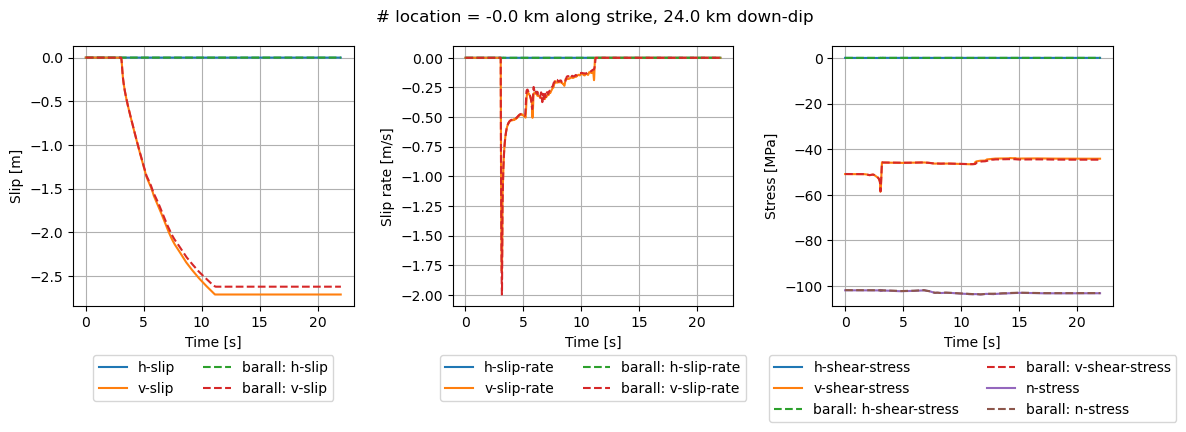

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst120dp120.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp120.dat


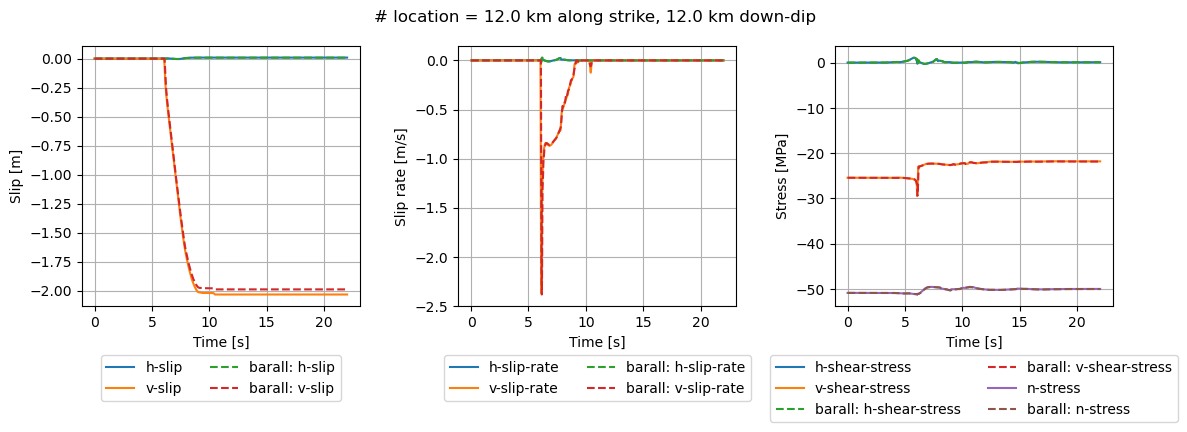

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst040dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp000.dat


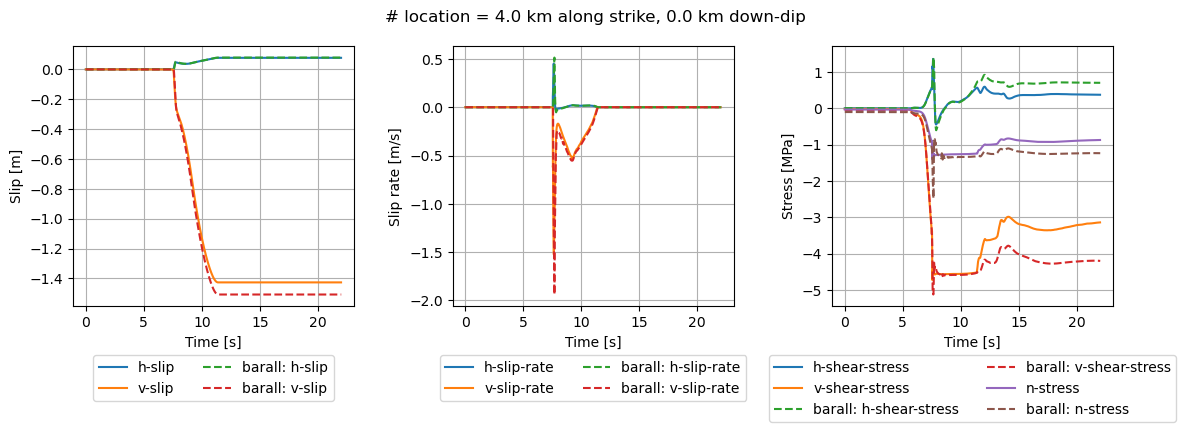

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst080dp060.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp060.dat


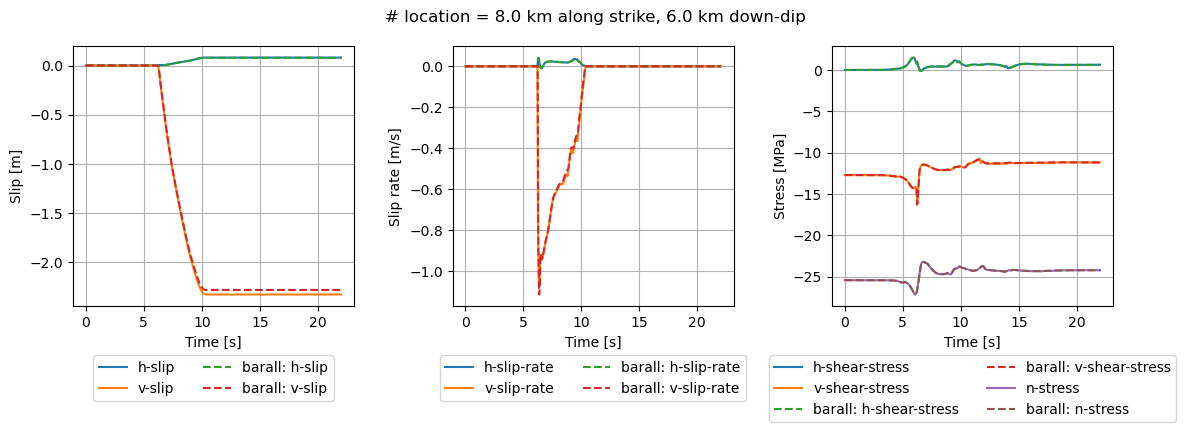

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst000dp060.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp060.dat


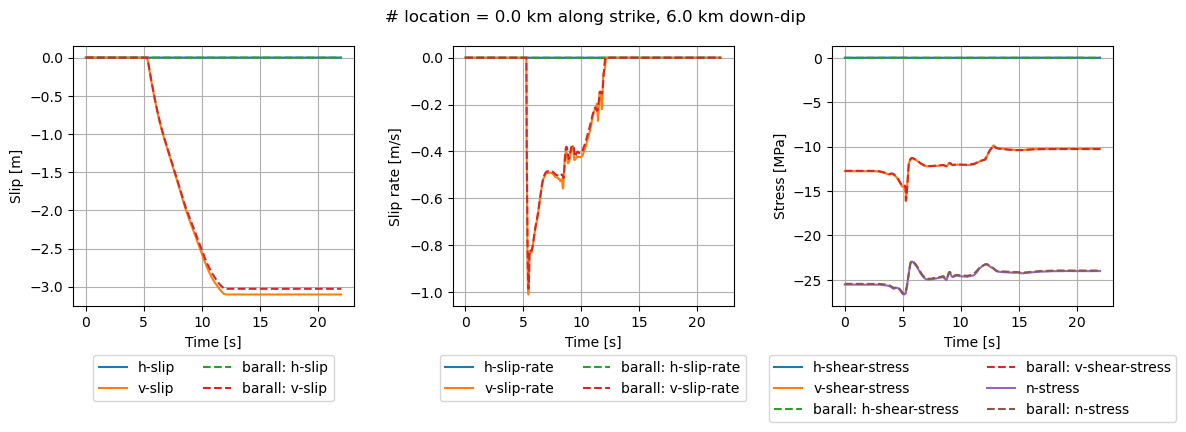

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst040dp030.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp030.dat


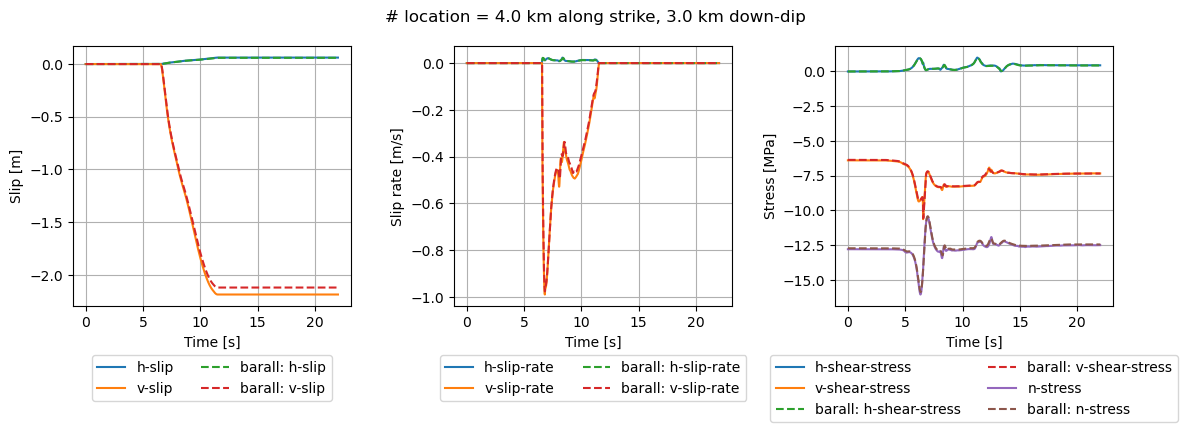

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst040dp180.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp180.dat


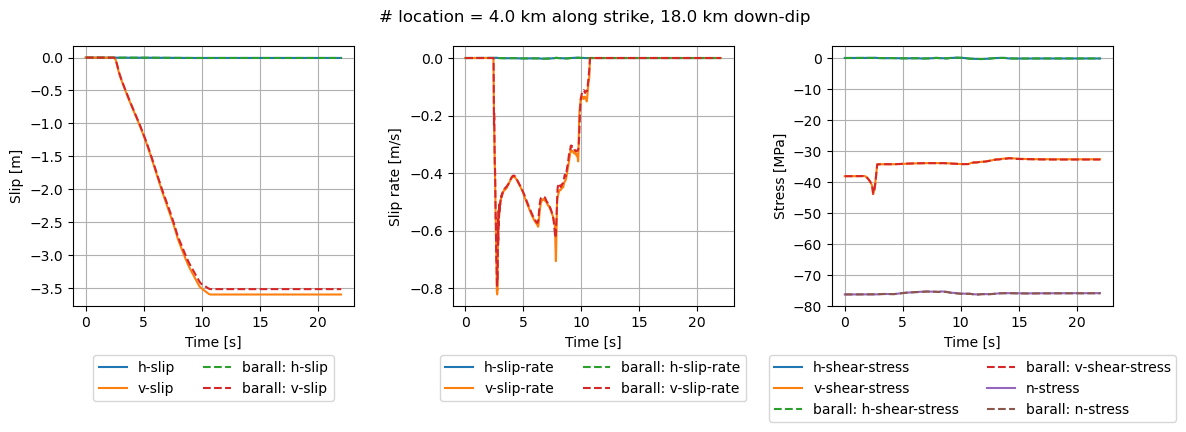

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst120dp060.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp060.dat


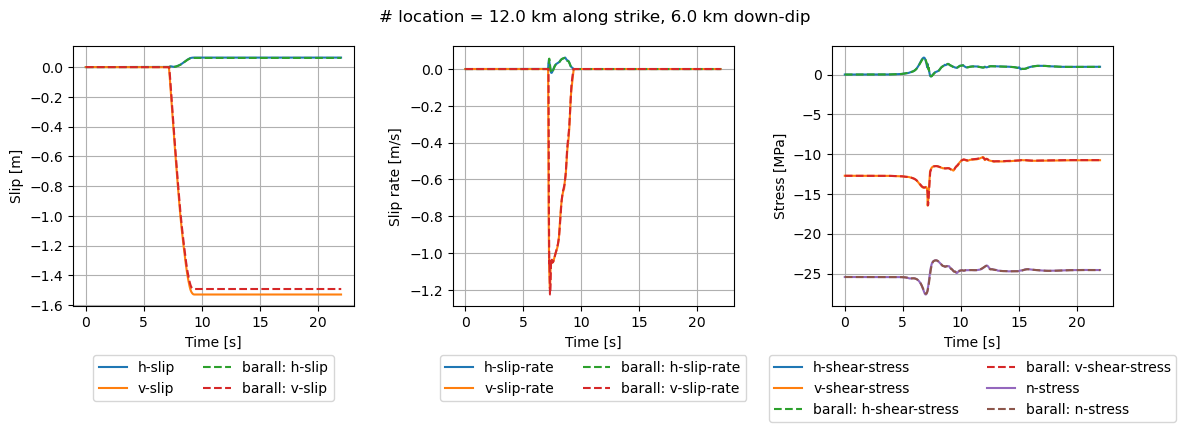

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst080dp120.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp120.dat


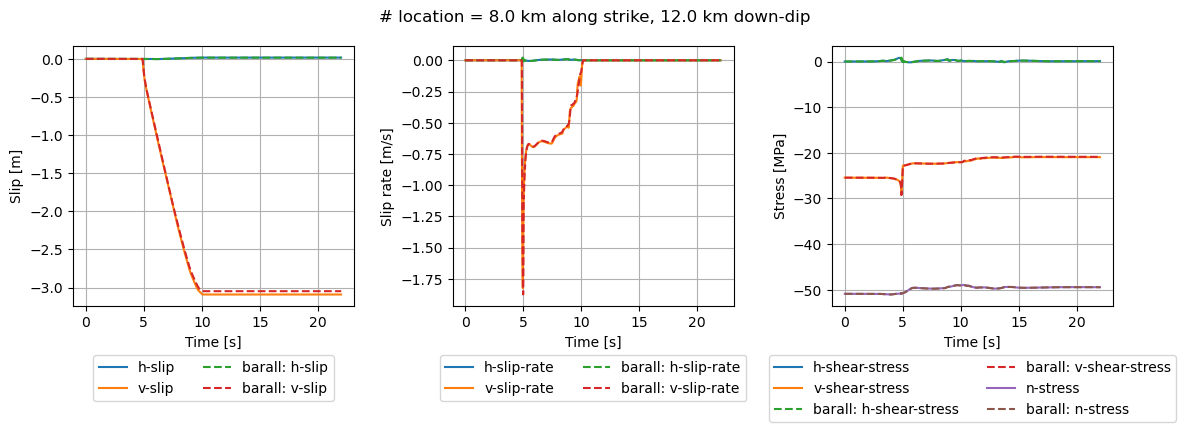

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst000dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp000.dat


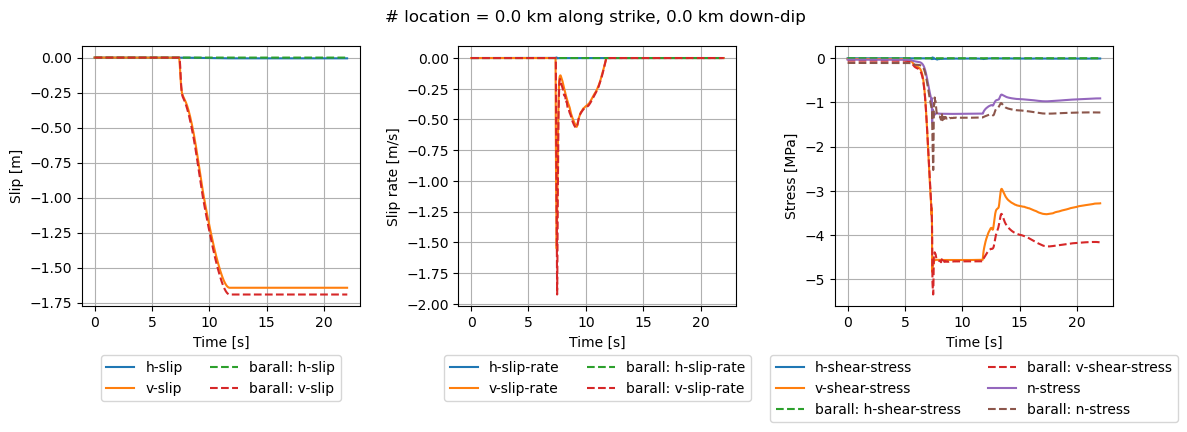

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst080dp030.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp030.dat


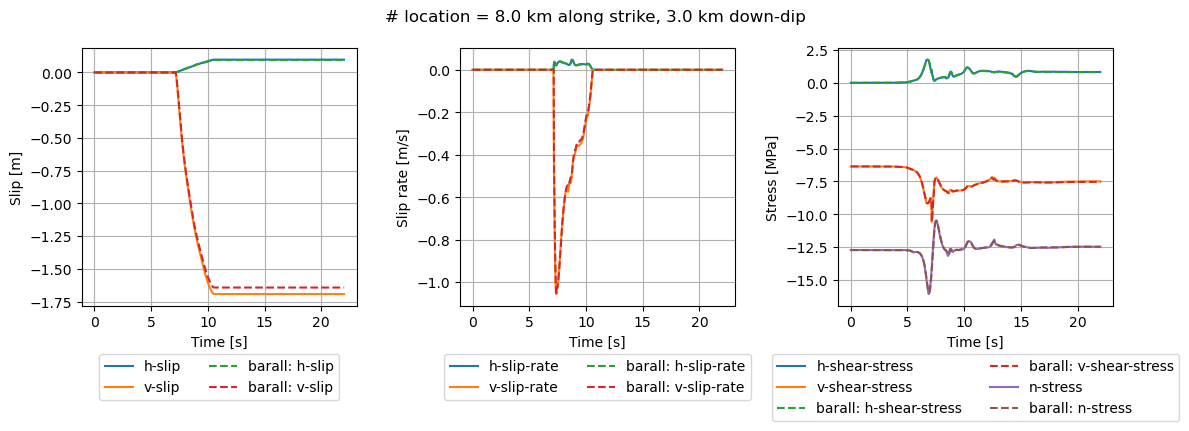

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst040dp120.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst040dp120.dat


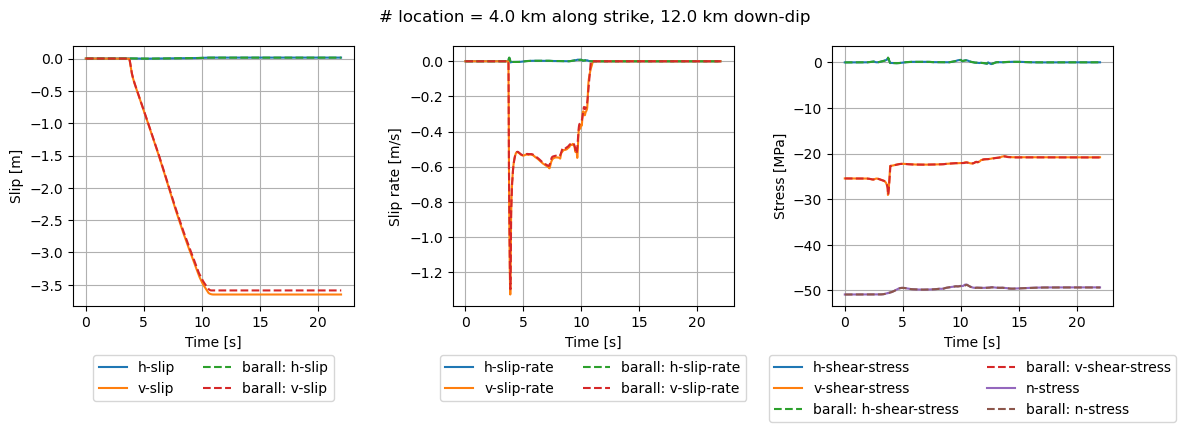

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst000dp010.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst000dp010.dat


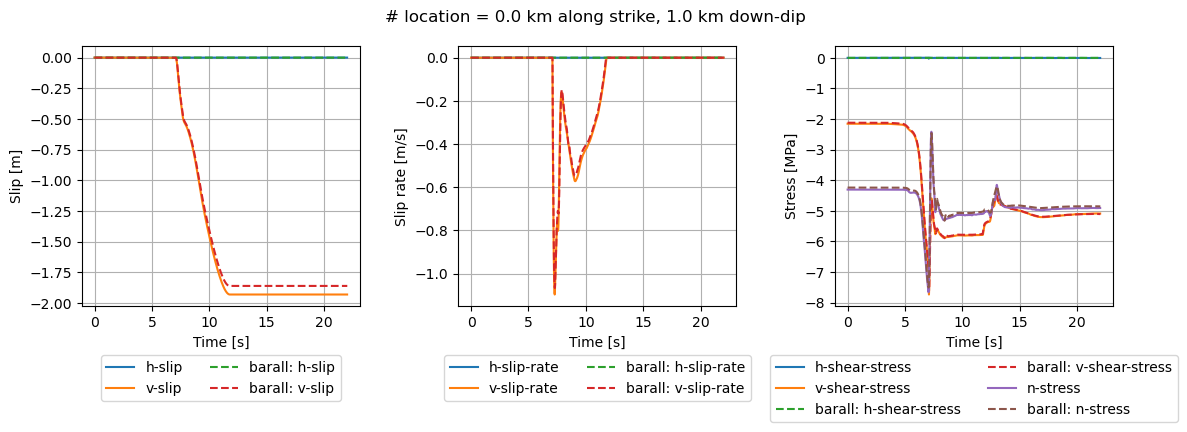

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst120dp000.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst120dp000.dat


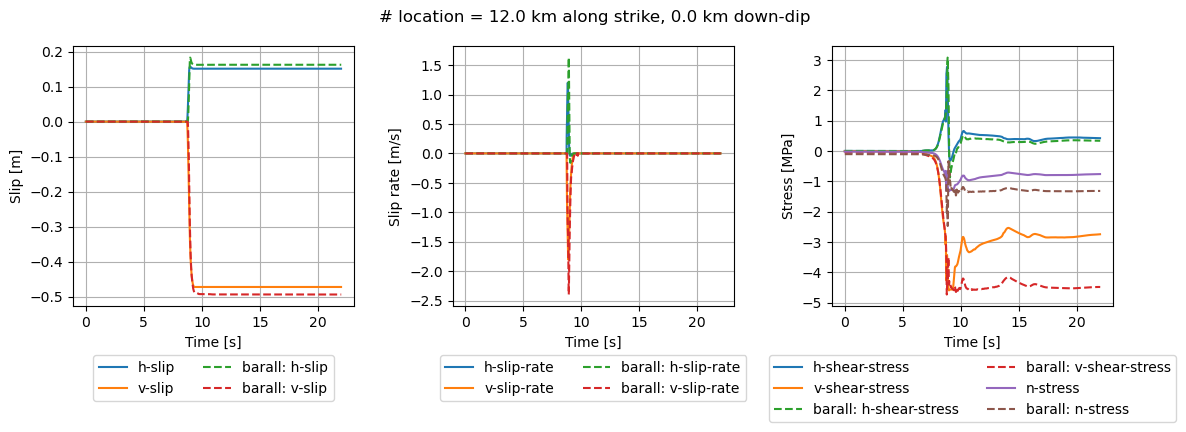

/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/kutschera_branch_Zihua_v1/faultst080dp180.csv
/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/faultst080dp180.dat


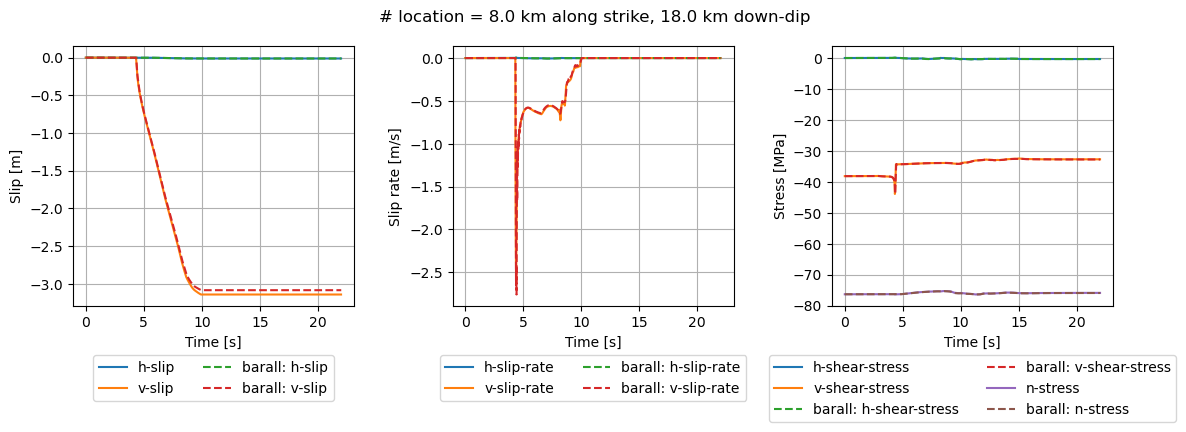

In [11]:
filenames = "fault*.csv"

files = glob.glob(os.path.join(output_folder, filenames))
for f in files:
    print(f)

    df_title = pd.read_csv(f, skiprows=8, nrows=1, sep=";", header=None) #arbitray separator
    title = df_title.iloc[0][0]
    
    df = pd.read_csv(f, sep="\s+", comment="#")

    f_barall = "/Users/fkutschera/Documents/Data/CRESCENT/tpv36_data/barall/"+f[-19:-4]+".dat"
    print(f_barall)
    barall = pd.read_csv(f_barall, sep="\s+", comment="#") 

    # Create figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))
    fig.suptitle(title)

    # Plot slip 
    ax1.plot(df["t"], df["h-slip"], label="h-slip")
    ax1.plot(df["t"], df["v-slip"], label="v-slip")
    ax1.plot(barall["t"], barall["h-slip"], label="barall: h-slip", linestyle="dashed")
    ax1.plot(barall["t"], barall["v-slip"], label="barall: v-slip", linestyle="dashed")
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Slip [m]")
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax1.grid(True)

    # Plot slip rate
    ax2.plot(df["t"], df["h-slip-rate"], label="h-slip-rate")
    ax2.plot(df["t"], df["v-slip-rate"], label="v-slip-rate")
    ax2.plot(barall["t"], barall["h-slip-rate"], label="barall: h-slip-rate", linestyle="dashed")
    ax2.plot(barall["t"], barall["v-slip-rate"], label="barall: v-slip-rate", linestyle="dashed")
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Slip rate [m/s]")
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax2.grid(True)

    # Plot stress
    ax3.plot(df["t"], df["h-shear-stress"], label="h-shear-stress")
    ax3.plot(df["t"], df["v-shear-stress"], label="v-shear-stress") 
    ax3.plot(barall["t"], barall["h-shear-stress"], label="barall: h-shear-stress", linestyle="dashed")
    ax3.plot(barall["t"], barall["v-shear-stress"], label="barall: v-shear-stress", linestyle="dashed") 
    ax3.plot(df["t"], df["n-stress"], label="n-stress")
    ax3.plot(barall["t"], barall["n-stress"], label="barall: n-stress", linestyle="dashed")
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Stress [MPa]")
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), ncol=2)
    ax3.grid(True)

    # Adjust layout and display
    plt.tight_layout()
    fig.savefig(output_folder + "/" + f[-19:-4] + ".png", dpi=300)
    plt.show()